In [ ]:
from meadowlark import Meadowlark

slm = Meadowlark(
    verbose=True,
    sdk_path="C:\\Program Files\\Meadowlark Optics\\Blink OverDrive Plus",
    # lut_path="C:\\Program Files\\Meadowlark Optics\\SDK\\slm5691_at635.LUT",
    lut_path="C:\\Program Files\\Meadowlark Optics\\SDK\\1920x1152_linearVoltage.LUT",
    wav_um=0.532,
    pitch_um=(9.2, 9.2),
)

# print(slm.shape)




Validating DPI awareness...success
Loading Blink SDK libraries...success
Initializing SDK...success
Found 1 SLM controller(s)
Loading LUT file...success
(1152, 1920)


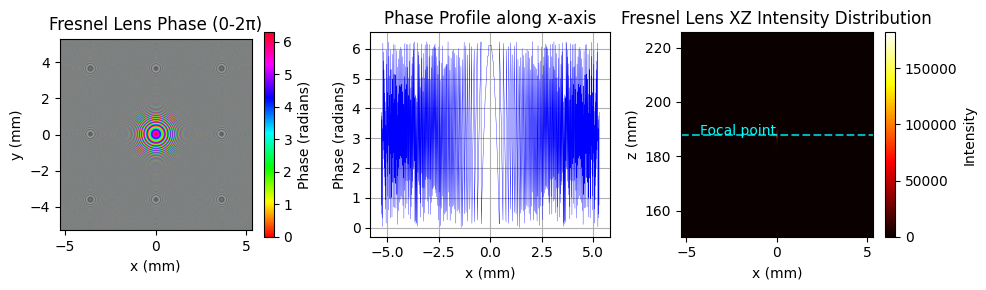

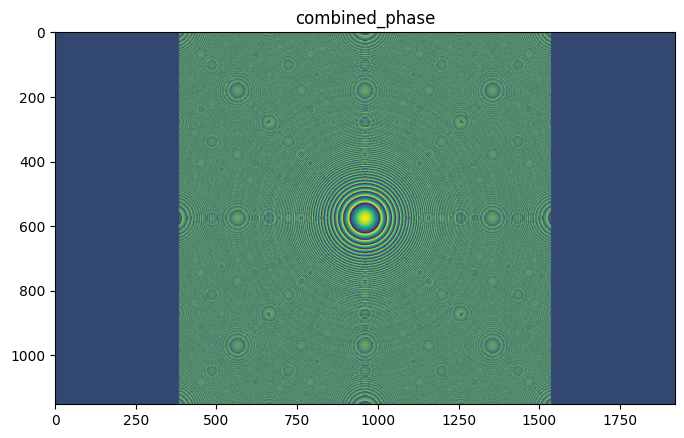

array([[  0, 127,   0, ..., 127,   0, 127],
       [127,   0, 127, ...,   0, 127,   0],
       [  0, 127,   0, ..., 127,   0, 127],
       ...,
       [127,   0, 127, ...,   0, 127,   0],
       [  0, 127,   0, ..., 127,   0, 127],
       [127,   0, 127, ...,   0, 127,   0]], dtype=uint8)

In [13]:
"""
简化的示例程序，菲涅尔透镜XZ平面光强分布的计算和显示
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import wave_propagation as wp

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 基本参数
wavelength = 532e-9   
focal_length = 188e-3  
N = 1152   
L = 9.2e-6 * N

# 创建坐标网格
X, Y = wp.create_grid(L, N, device)

# 创建菲涅尔透镜相位
phase = wp.fresnel_lens_phase(X, Y, focal_length, wavelength)

# 入射场
U_in = torch.ones((N, N), device=device, dtype=torch.complex64)
U_lens = U_in * torch.exp(1j * phase)

# 设置z位置（焦点附近）
z_start = 0.8 * focal_length
z_end = 1.2 * focal_length
num_z = 101  # 减少z方向采样点以加速计算
z_positions = np.linspace(z_start, z_end, num_z)

# 初始化xz强度数据
xz_intensity = np.zeros((num_z, N))
y_mid = N // 2

# 计算XZ平面
for i, z in enumerate(z_positions):
    # 传播到z平面
    U_z = wp.propagate_ASM(U_lens, z, L, wavelength, device)
    # 保存y中间一行的强度作为xz切片
    intensity = torch.abs(U_z)**2
    xz_intensity[i, :] = intensity[y_mid, :].cpu().detach().numpy()

# 显示
plt.figure(figsize=(10, 3))

# 面板1: 包裹相位 (0-2π)
plt.subplot(1, 3, 1)
phase_np = phase.cpu().detach().numpy()
wrapped_phase = np.mod(phase_np, 2*np.pi)
im1 = plt.imshow(wrapped_phase, extent=[-L/2*1000, L/2*1000, -L/2*1000, L/2*1000], 
                cmap='hsv', norm=Normalize(0, 2*np.pi))
plt.colorbar(im1, label='Phase (radians)')
plt.title('Fresnel Lens Phase (0-2π)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

# 面板2: 沿x轴的相位剖面
plt.subplot(1, 3, 2)
plt.plot(X[N//2, :].cpu().numpy()*1000, wrapped_phase[N//2, :], 'b-', linewidth=0.25)
plt.grid(True)
plt.title('Phase Profile along x-axis')
plt.xlabel('x (mm)')
plt.ylabel('Phase (radians)')

# 使用正确的extent参数设置物理尺寸（单位:mm）
plt.subplot(1, 3, 3)
extent = [-L/2*1000, L/2*1000, z_start*1000, z_end*1000]
plt.imshow(xz_intensity, extent=extent, aspect='auto', origin='lower', cmap='hot')
plt.colorbar(label='Intensity')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.title('Fresnel Lens XZ Intensity Distribution')

# 标记焦点
plt.axhline(y=focal_length*1000, color='cyan', linestyle='--', alpha=0.7)
plt.text(-L/2*1000*0.8, focal_length*1000, 'Focal point', color='cyan')

plt.tight_layout()
plt.show()

## load to SLM
def create_checkerboard(shape):
    y, x = np.indices(shape)
    return np.uint8(np.pi * ((x + y) % 2) / (2 * np.pi) * 255)

def center_array(B, A):
  # Places the smaller array A into the center of a copy of the larger array B.
  C = B.copy()  
  start_indices = (np.array(B.shape) - np.array(A.shape)) // 2
  end_indices = start_indices + np.array(A.shape)
  center_slice = tuple(slice(start, end) for start, end in zip(start_indices, end_indices))
  C[center_slice] = A
  return C

checkerboard = create_checkerboard(slm.shape)
phi = np.uint8(phase.detach().cpu().numpy() / (2 * np.pi) * 255)
combined_phase = center_array(checkerboard, phi)


plt.figure(figsize=(8, 6))
plt.imshow(combined_phase, cmap='viridis')
plt.title('combined_phase')
plt.show()

# upload to SLM
slm.set_phase(combined_phase)

In [20]:
mask.shape

(1152, 1920)

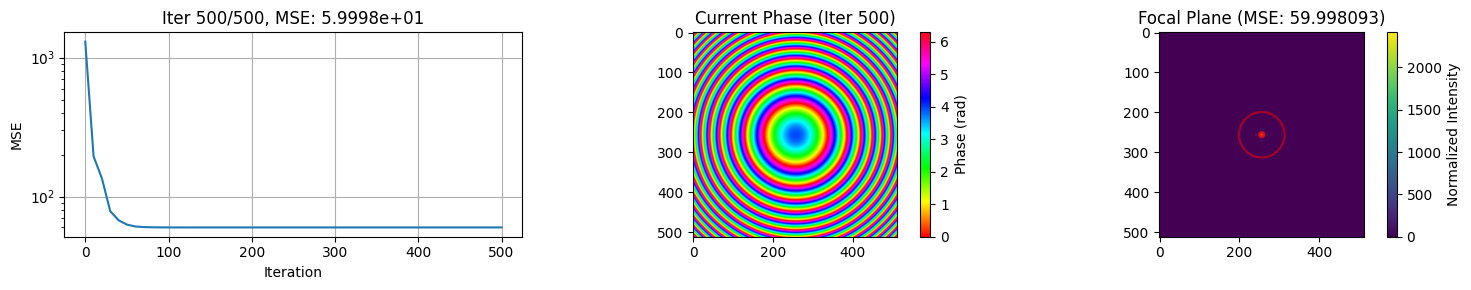

Finished. Time: 13.23 sec

MSE比较:
随机相位: 1.3050e+03
理想菲涅尔透镜: 1.3649e+02
优化相位: 5.9998e+01


<Figure size 1200x500 with 0 Axes>

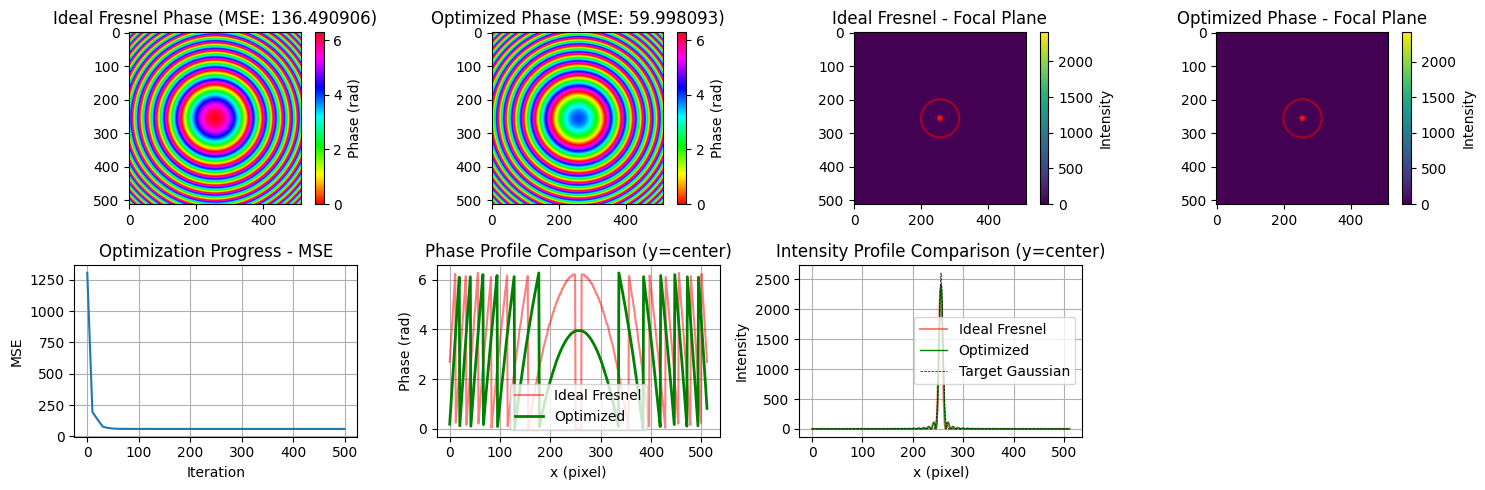

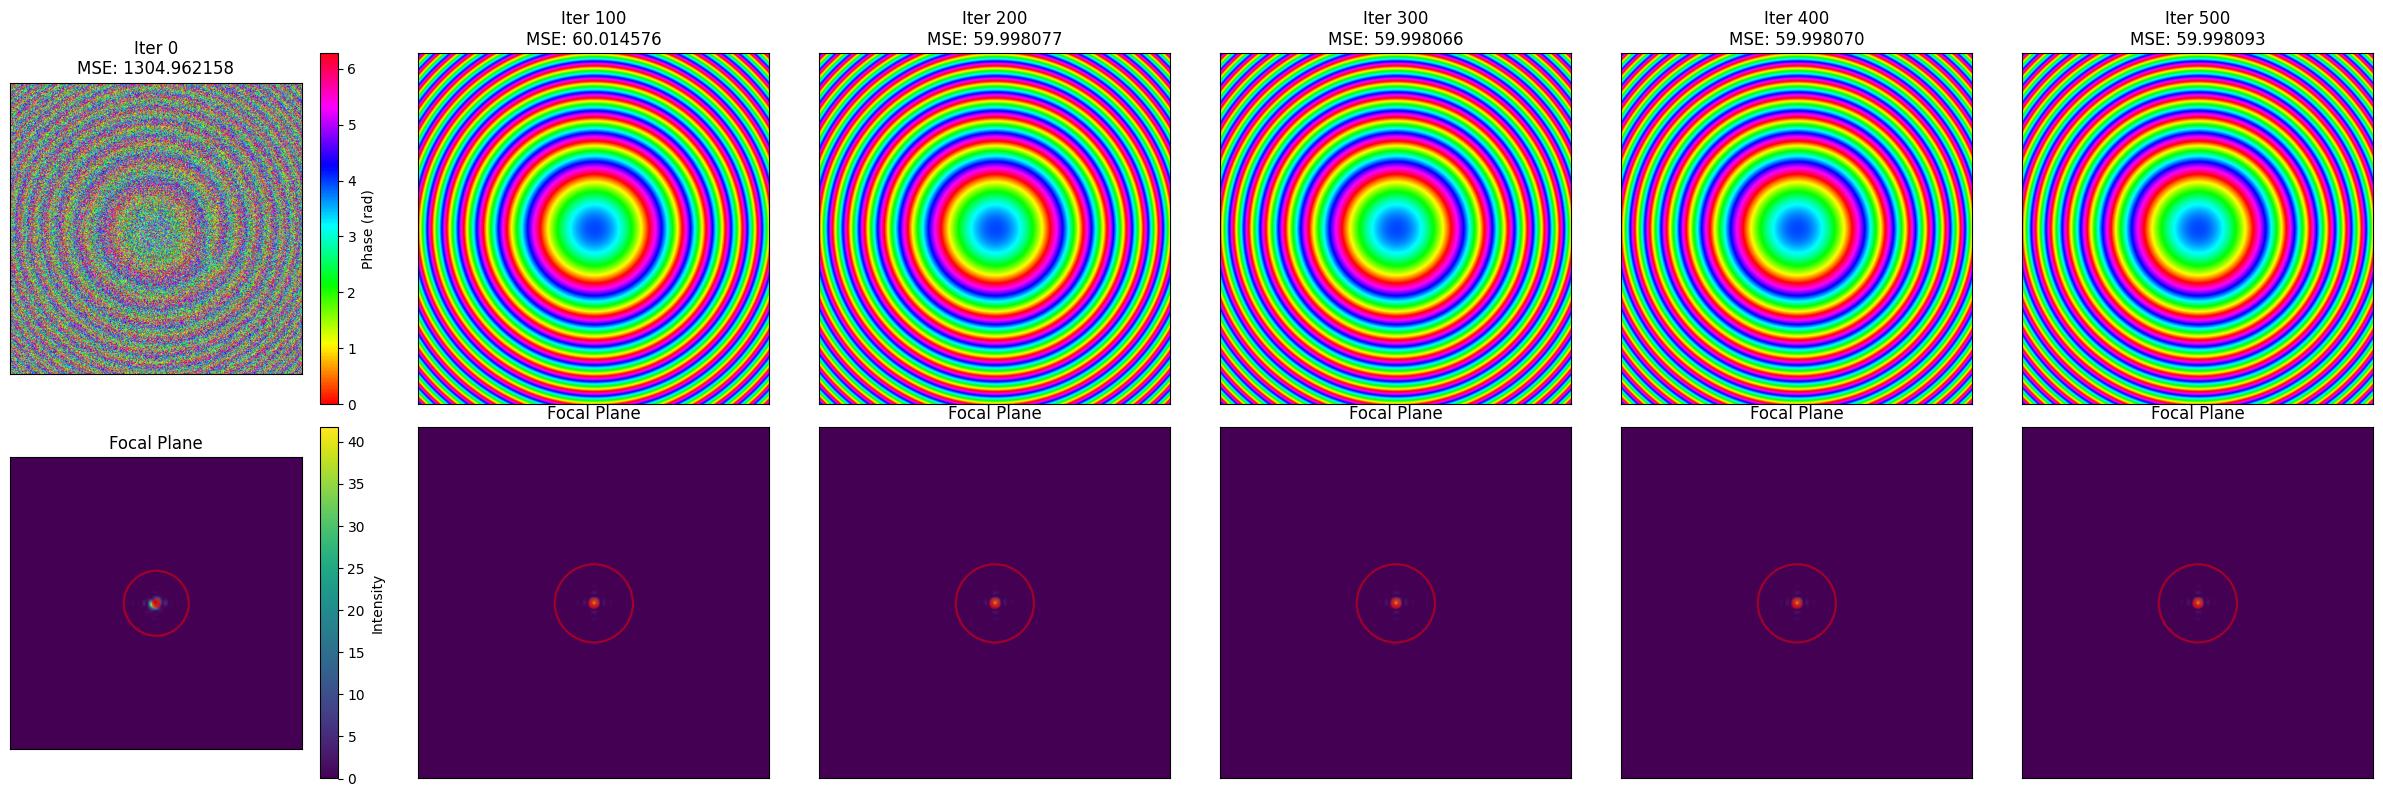

In [1]:
"""
基于高斯模板的菲涅尔透镜相位优化程序
使用Adam优化器和MSE损失函数优化相位分布，以匹配基于衍射极限的高斯焦点模式
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import wave_propagation as wp

class PhaseOptimizerGaussian:
    
    def __init__(self, N, L, wavelength, focal_length, device=None):
        self.N = N
        self.L = L
        self.wavelength = wavelength
        self.focal_length = focal_length
        self.dof_tol_factor = 2
        self.psf_tol_factor = 0.8
        self.depth_of_focus = 8*wavelength/np.pi*np.sqrt(self.dof_tol_factor**2-1)*(focal_length/L)**2
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"使用设备: {self.device}")
        
        # 创建坐标网格
        self.X, self.Y = wp.create_grid(L, N, self.device)
        
        # 初始化相位为随机值（需要梯度）
        self.random_phase = torch.rand((N, N), device=self.device) * 2 * np.pi
        self.phase_param = torch.nn.Parameter(self.random_phase.clone())
        
        # 计算理想菲涅尔透镜相位（用于比较）
        self.ideal_phase = wp.fresnel_lens_phase(self.X, self.Y, focal_length, wavelength)
        
        # 入射场：单位振幅平面波
        self.U_in = torch.ones((N, N), device=self.device, dtype=torch.complex64)
        
        # 创建目标高斯模板
        self.target_gaussian = self.create_gaussian_template(self.psf_tol_factor)
        
        # 初始化历史记录
        self.loss_history = []
        self.mse_history = []
        self.phase_history = []
        
    def create_gaussian_template(self,size_factor=1.0):
        # 计算衍射极限的艾里斑半径（单位：米）
        # r_airy = 1.22 * lambda * f / D * size_factor
        r_airy = 1.22 * self.wavelength * self.focal_length *size_factor / self.L
        
        # 高斯宽度参数（单位：米）
        # 标准偏差sigma约为艾里半径的0.42倍
        sigma = 0.42 * r_airy
        
        # 将sigma转换为像素单位
        pitch = self.L / self.N  # 采样间隔（米/像素）
        sigma_px = sigma / pitch
        
        print(f"衍射极限参数:")
        print(f"艾里斑半径: {r_airy:.3e} 米, {r_airy/pitch:.2f} 像素")
        print(f"高斯宽度σ: {sigma:.3e} 米, {sigma_px:.2f} 像素")
        
        # 精确的中心点（考虑奇偶性）
        if self.N % 2 == 0:  # 偶数
            center_x = center_y = self.N / 2
        else:  # 奇数
            center_x = center_y = (self.N - 1) / 2
            
        # 创建坐标网格
        y = torch.arange(self.N, device=self.device)
        x = torch.arange(self.N, device=self.device)
        Y, X = torch.meshgrid(y, x, indexing='ij')
        
        # 计算到中心的距离平方
        dist_sq = (X - center_x)**2 + (Y - center_y)**2
        
        # 创建高斯分布
        # 用2倍的方差表示光强分布
        gaussian = torch.exp(-0.5 * dist_sq / (sigma_px**2))
        
        # 归一化
        gaussian = gaussian / torch.sum(gaussian) * torch.numel(gaussian)
        return gaussian
    
    def forward(self, phase, z):
        U_phase = self.U_in * torch.exp(1j * phase)
        U_focal = wp.propagate_ASM(U_phase, z, self.L, self.wavelength, self.device)
        I_focal = torch.abs(U_focal)**2
        return I_focal
    
    def compute_loss(self, phase):
        # # 计算强度
        # I_focal_1 = self.forward(phase, self.focal_length + self.depth_of_focus/2)
        # I_focal_2 = self.forward(phase, self.focal_length - self.depth_of_focus/2)
        # # 计算与高斯模板的MSE
        # mse = torch.mean((I_focal_1 - self.target_gaussian)**2) + torch.mean((I_focal_2 - self.target_gaussian)**2)
        # 计算强度
        I_focal = self.forward(phase, self.focal_length)
        # 计算与高斯模板的MSE
        mse = torch.mean((I_focal - self.target_gaussian)**2)
        return mse, mse.item()
    
    def optimize(self, num_iterations=200, learning_rate=0.01, 
                save_interval=10, live_update=True):
        
        start_time = time.time()
        
        print(f"开始优化，共 {num_iterations} 次迭代...")
        
        # 创建优化器
        optimizer = torch.optim.Adam([self.phase_param], lr=learning_rate)
        
        # 创建图形对象（用于实时更新）
        if live_update:
            plt.figure(figsize=(12, 5))
        
        # 优化循环
        for iter_idx in range(num_iterations):
            # 零梯度
            optimizer.zero_grad()
            
            # 计算损失（与高斯模板的MSE）
            loss, mse = self.compute_loss(self.phase_param)
            
            # 反向传播
            loss.backward()
            
            # 更新参数
            optimizer.step()
            
            # 记录历史（每隔一定间隔）
            if iter_idx % save_interval == 0 or iter_idx == num_iterations - 1:
                self.loss_history.append(loss.item())
                self.mse_history.append(mse)
                self.phase_history.append(self.phase_param.detach().clone())
                
                # 实时可视化（仅在Jupyter中使用）
                if live_update and (iter_idx % (save_interval * 5) == 0 or iter_idx == num_iterations - 1):
                    clear_output(wait=True)
                    # 创建图形
                    plt.figure(figsize=(15, 3))
                    # 左：MSE曲线
                    plt.subplot(1, 3, 1)
                    plt.semilogy(np.arange(len(self.mse_history)) * save_interval, self.mse_history)
                    plt.grid(True)
                    plt.xlabel('Iteration')
                    plt.ylabel('MSE')
                    plt.title(f'Iter {iter_idx+1}/{num_iterations}, MSE: {mse:.4e}')
                    # 中：当前相位
                    plt.subplot(1, 3, 2)
                    wrapped_phase = torch.remainder(self.phase_param.detach(), 2*np.pi).cpu().numpy()
                    plt.imshow(wrapped_phase, cmap='hsv', vmin=0, vmax=2*np.pi)
                    plt.colorbar(label='Phase (rad)')
                    plt.title(f'Current Phase (Iter {iter_idx+1})')
                    # 右：当前焦平面强度与目标比较
                    plt.subplot(1, 3, 3)
                    I_focal = self.forward(self.phase_param.detach(), self.focal_length)
                    plt.imshow(I_focal.cpu().numpy(), cmap='viridis')
                    plt.colorbar(label='Normalized Intensity')
                    plt.contour(self.target_gaussian.cpu().numpy(), colors='r', levels=4, alpha=0.5)
                    plt.title(f'Focal Plane (MSE: {mse:.6f})')
                    
                    plt.tight_layout()
                    display(plt.gcf())
                    plt.close()
                    
        
        # 获取优化后的相位
        optimized_phase = self.phase_param.detach().clone()
        
        # 优化完成
        elapsed_time = time.time() - start_time
        print(f"Finished. Time: {elapsed_time:.2f} sec")
        
        return optimized_phase
    
    def visualize_results(self, optimized_phase):
        """
        可视化优化结果
        
        参数:
            optimized_phase: 优化后的相位分布
        """
        # 相位包裹到 0-2π
        wrapped_random = torch.remainder(self.random_phase, 2*np.pi).cpu().numpy()
        wrapped_ideal = torch.remainder(self.ideal_phase, 2*np.pi).cpu().numpy()
        wrapped_optimized = torch.remainder(optimized_phase, 2*np.pi).cpu().numpy()
        
        # 计算各阶段的焦平面场和强度
        I_random = self.forward(self.random_phase, self.focal_length)
        I_ideal = self.forward(self.ideal_phase, self.focal_length)
        I_optimized = self.forward(optimized_phase, self.focal_length)
        
        # 计算与高斯模板的MSE
        mse_random = torch.mean((I_random - self.target_gaussian)**2).item()
        mse_ideal = torch.mean((I_ideal - self.target_gaussian)**2).item()
        mse_optimized = torch.mean((I_optimized - self.target_gaussian)**2).item()
        
        print(f"\nMSE比较:")
        print(f"随机相位: {mse_random:.4e}")
        print(f"理想菲涅尔透镜: {mse_ideal:.4e}")
        print(f"优化相位: {mse_optimized:.4e}")
        
        # 创建图形
        plt.figure(figsize=(15, 5))
        
        # 1. 相位分布比较
        plt.subplot(2, 4, 1)
        plt.imshow(wrapped_ideal, cmap='hsv', vmin=0, vmax=2*np.pi)
        plt.colorbar(label='Phase (rad)')
        plt.title(f'Ideal Fresnel Phase (MSE: {mse_ideal:.6f})')
        
        plt.subplot(2, 4, 2)
        plt.imshow(wrapped_optimized, cmap='hsv', vmin=0, vmax=2*np.pi)
        plt.colorbar(label='Phase (rad)')
        plt.title(f'Optimized Phase (MSE: {mse_optimized:.6f})')
        
        # 2. 焦平面强度比较
        plt.subplot(2, 4, 3)
        plt.imshow(I_ideal.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Intensity')
        plt.contour(self.target_gaussian.cpu().numpy(), colors='r', levels=4, alpha=0.5)
        plt.title('Ideal Fresnel - Focal Plane')
        plt.subplot(2, 4, 4)
        plt.imshow(I_optimized.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Intensity')
        plt.contour(self.target_gaussian.cpu().numpy(), colors='r', levels=4, alpha=0.5)
        plt.title('Optimized Phase - Focal Plane')
        
        # 优化过程
        plt.subplot(2, 4, 5)
        plt.plot(np.arange(len(self.mse_history)) * 10, self.mse_history)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Optimization Progress - MSE')
        
        # 相位剖面比较
        center_y = self.N // 2
        plt.subplot(2, 4, 6)
        plt.plot(wrapped_ideal[center_y, :], 'r-', alpha=0.5, label='Ideal Fresnel')
        plt.plot(wrapped_optimized[center_y, :], 'g-', linewidth=2, label='Optimized')
        plt.grid(True)
        plt.xlabel('x (pixel)')
        plt.ylabel('Phase (rad)')
        plt.legend()
        plt.title('Phase Profile Comparison (y=center)')
        
        # 5. 强度剖面比较
        plt.subplot(2, 4, 7)
        plt.plot(I_ideal[center_y, :].cpu().numpy(), 'r-', alpha=0.5, label='Ideal Fresnel')
        plt.plot(I_optimized[center_y, :].cpu().numpy(), 'g-', linewidth=1, label='Optimized')
        plt.plot(self.target_gaussian[center_y, :].cpu().numpy(), 'k--', linewidth=0.5, label='Target Gaussian')
        plt.grid(True)
        plt.xlabel('x (pixel)')
        plt.ylabel('Intensity')
        plt.legend()
        plt.title('Intensity Profile Comparison (y=center)')
        
        plt.tight_layout()
        plt.show()
        
    
    def visualize_optimization_steps(self, num_steps=5):
        """
        可视化优化过程中的关键步骤（适用于Jupyter Notebook）
        
        参数:
            num_steps: 要显示的步骤数量
        """
        if len(self.phase_history) < num_steps:
            print(f"历史记录不足，仅有{len(self.phase_history)}个记录点")
            num_steps = len(self.phase_history)
        
        # 选择要显示的步骤
        step_indices = np.linspace(0, len(self.phase_history) - 1, num_steps, dtype=int)
        
        # 创建大图形
        fig, axes = plt.subplots(2, num_steps, figsize=(4*num_steps, 8))
        
        for i, idx in enumerate(step_indices):
            # 获取该步骤的相位和MSE
            phase = self.phase_history[idx]
            mse = self.mse_history[idx]
            iteration = idx * 10  # 假设每10次迭代保存一次
            
            # 包裹相位
            wrapped_phase = torch.remainder(phase, 2*np.pi).cpu().numpy()
            
            # 计算焦平面强度
            I_focal = self.forward(phase, self.focal_length)
            
            # 绘制相位
            ax_phase = axes[0, i]
            im_phase = ax_phase.imshow(wrapped_phase, cmap='hsv', vmin=0, vmax=2*np.pi)
            ax_phase.set_title(f'Iter {iteration}\nMSE: {mse:.6f}')
            if i == 0:
                fig.colorbar(im_phase, ax=ax_phase, label='Phase (rad)')
            
            # 绘制焦平面强度
            ax_focal = axes[1, i]
            im_focal = ax_focal.imshow(I_focal.cpu().numpy(), cmap='viridis')
            ax_focal.contour(self.target_gaussian.cpu().numpy(), colors='r', levels=4, alpha=0.5)
            ax_focal.set_title('Focal Plane')
            if i == 0:
                fig.colorbar(im_focal, ax=ax_focal, label='Intensity')
                
            # 移除刻度以简化显示
            ax_phase.set_xticks([])
            ax_phase.set_yticks([])
            ax_focal.set_xticks([])
            ax_focal.set_yticks([])
        
        plt.tight_layout()
        plt.show()

# 主函数示例
"""
运行基于修正高斯模板的优化程序
"""
# 设置参数
N = 512             # 网格点数
L = 0.002           # 计算区域大小（1mm）
wavelength = 635e-9  # 波长（635nm）
focal_length = 0.120 # 焦距（5mm）

# 创建优化器
optimizer = PhaseOptimizerGaussian(N, L, wavelength, focal_length)

# 优化相位
num_iterations = 500
learning_rate = 0.3
optimized_phase = optimizer.optimize(
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    save_interval=10,
    live_update=True  # 在Jupyter中实时更新
)

# 可视化最终结果
optimizer.visualize_results(optimized_phase)

# 可视化优化过程关键步骤
optimizer.visualize_optimization_steps(num_steps=6)

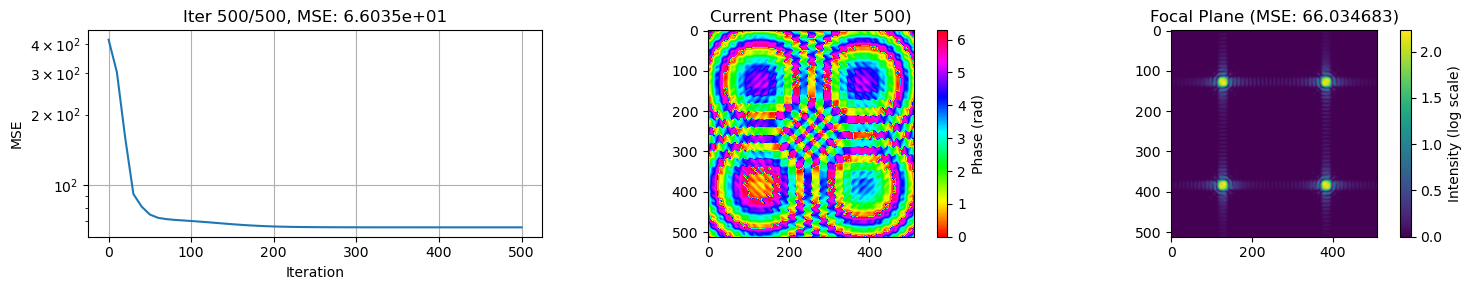

Finished. Time: 15.59 sec


<Figure size 1200x500 with 0 Axes>

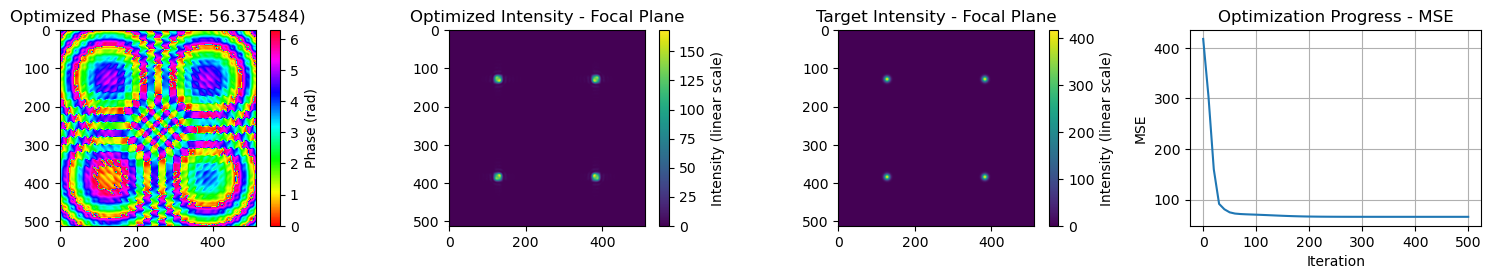

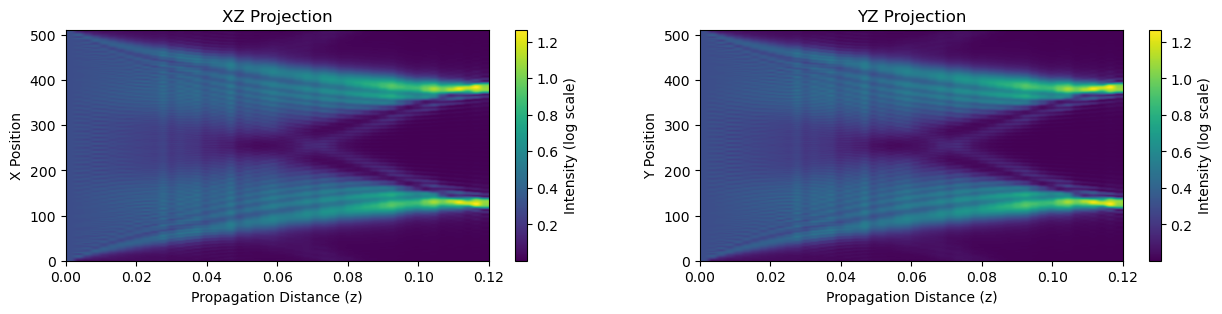

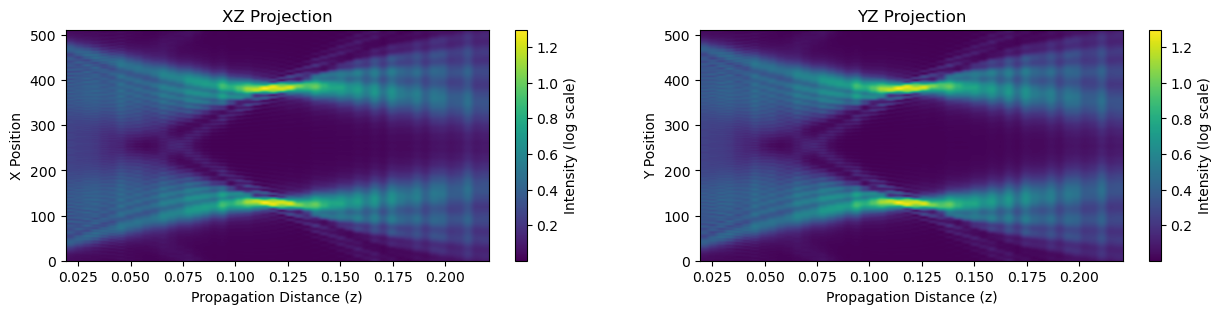

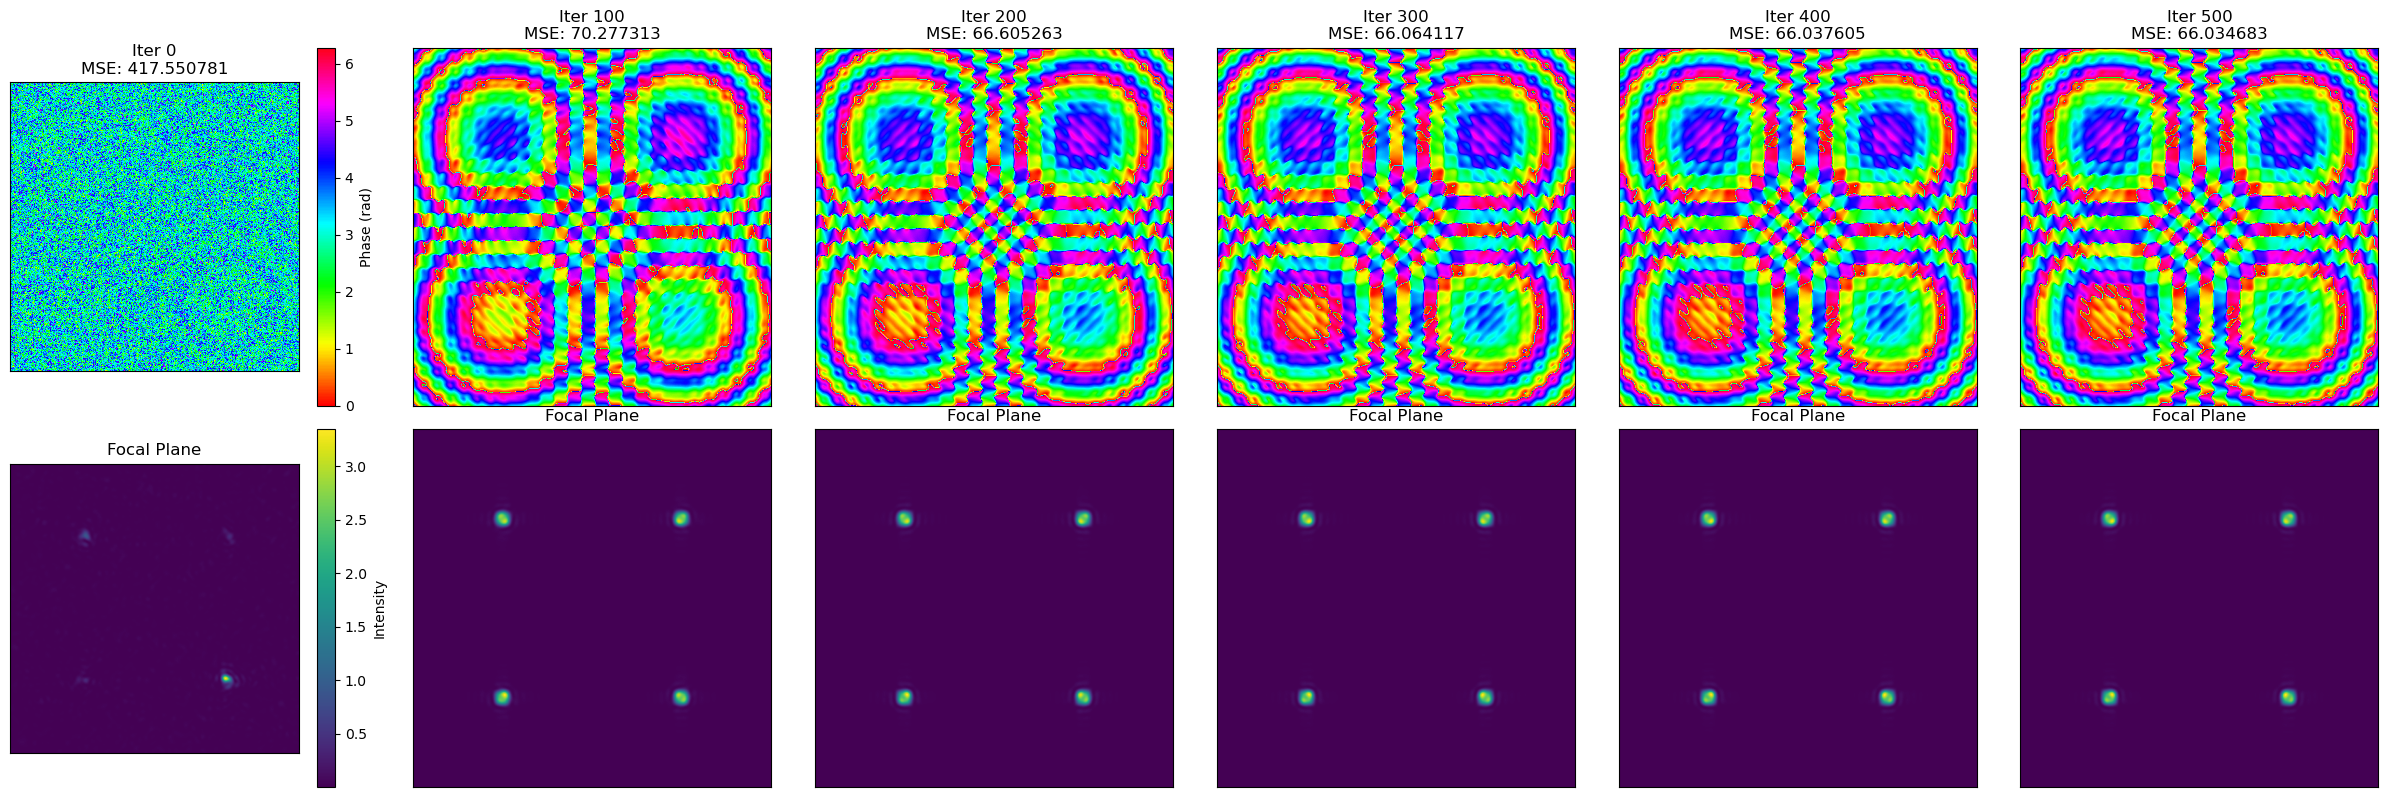

In [39]:
"""
基于高斯模板的透镜阵列相位优化程序
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import wave_propagation as wp

class PhaseOptimizerMulti:
    
    def __init__(self, N, L, wavelength, focal_length, 
                 dof_tol_factor=2, 
                 psf_tol_factor=0.8, 
                 psf_pos_x=[0.5], psf_pos_y=[0.5],
                 device=None):
        self.N = N
        self.L = L
        self.wavelength = wavelength
        self.focal_length = focal_length
        self.dof_tol_factor = dof_tol_factor
        self.psf_tol_factor = psf_tol_factor
        self.psf_pos_x = psf_pos_x
        self.psf_pos_y = psf_pos_y
        self.depth_of_focus = 8*wavelength/np.pi*np.sqrt(self.dof_tol_factor**2-1)*(focal_length/L)**2
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"使用设备: {self.device}")
        
        # 创建坐标网格
        self.X, self.Y = wp.create_grid(L, N, self.device)
        
        # 初始化相位为随机值（需要梯度）
        self.random_phase = torch.rand((N, N), device=self.device) * 2 * np.pi
        self.phase_param = torch.nn.Parameter(self.random_phase.clone())
        
        # 计算理想菲涅尔透镜相位（用于比较）
        self.ideal_phase = wp.fresnel_lens_phase(self.X, self.Y, focal_length, wavelength)
        
        # 入射场：单位振幅平面波
        self.U_in = torch.ones((N, N), device=self.device, dtype=torch.complex64)
        
        # 创建目标高斯模板
        self.target_gaussian = self.create_gaussian_template(self.psf_tol_factor, self.psf_pos_x, self.psf_pos_y)
        
        # 初始化历史记录
        self.loss_history = []
        self.mse_history = []
        self.phase_history = []
        
    def create_gaussian_template(self, size_factor=1.0, psf_pos_x=0.5, psf_pos_y=0.5):
        # 计算衍射极限的艾里斑半径（单位：米）
        r_airy = 1.22 * self.wavelength * self.focal_length * size_factor / self.L
        # 高斯宽度参数（单位：米）
        # 标准偏差sigma约为艾里半径的0.42倍
        sigma = 0.42 * r_airy
        # 将sigma转换为像素单位
        pitch = self.L / self.N  # 采样间隔（米/像素）
        sigma_px = sigma / pitch
        
        print(f"衍射极限参数:")
        print(f"艾里斑半径: {r_airy:.3e} 米, {r_airy/pitch:.2f} 像素")
        print(f"高斯宽度σ: {sigma:.3e} 米, {sigma_px:.2f} 像素")
        
        # 创建坐标网格
        y = torch.arange(self.N, device=self.device)
        x = torch.arange(self.N, device=self.device)
        Y, X = torch.meshgrid(y, x, indexing='ij')
        
        # 将位置参数转换为列表以便统一处理
        pos_x_list = psf_pos_x if isinstance(psf_pos_x, (list, tuple)) else [psf_pos_x]
        pos_y_list = psf_pos_y if isinstance(psf_pos_y, (list, tuple)) else [psf_pos_y]
        
        # 初始化累积高斯分布为零矩阵
        gaussian_sum = torch.zeros((self.N, self.N), device=self.device)
        
        # 为每个位置组合生成高斯分布并累加
        for pos_x in pos_x_list:
            for pos_y in pos_y_list:
                # 计算实际中心坐标
                center_x = pos_x * (self.N - 1)
                center_y = pos_y * (self.N - 1)
                
                # 计算到该中心的距离平方
                dist_sq = (X - center_x)**2 + (Y - center_y)**2
                
                # 创建高斯分布
                gaussian = torch.exp(-0.5 * dist_sq / (sigma_px**2))
                
                # 添加到累积总和
                gaussian_sum += gaussian
        
        # 使用累积的高斯分布
        gaussian = gaussian_sum
        
        # 归一化
        gaussian = gaussian / torch.sum(gaussian) * torch.numel(gaussian)
        return gaussian
    
    def forward(self, phase, z):
        U_phase = self.U_in * torch.exp(1j * phase)
        U_focal = wp.propagate_ASM(U_phase, z, self.L, self.wavelength, self.device)
        I_focal = torch.abs(U_focal)**2
        return I_focal
    
    def compute_loss(self, phase):
        # 计算强度
        I_focal_1 = self.forward(phase, self.focal_length + self.depth_of_focus/2)
        I_focal_2 = self.forward(phase, self.focal_length - self.depth_of_focus/2)
        # 计算与高斯模板的MSE
        mse = torch.mean((I_focal_1 - self.target_gaussian)**2) + torch.mean((I_focal_2 - self.target_gaussian)**2)
        # # 计算强度
        # I_focal = self.forward(phase, self.focal_length)
        # # 计算与高斯模板的MSE
        # mse = torch.mean((I_focal - self.target_gaussian)**2)
        return mse, mse.item()
    
    def optimize(self, num_iterations=200, learning_rate=0.01, 
                save_interval=10, live_update=True):
        
        start_time = time.time()
        
        print(f"开始优化，共 {num_iterations} 次迭代...")
        
        # 创建优化器
        optimizer = torch.optim.Adam([self.phase_param], lr=learning_rate)
        
        # 创建图形对象（用于实时更新）
        if live_update:
            plt.figure(figsize=(12, 5))
        
        # 优化循环
        for iter_idx in range(num_iterations):
            # 零梯度
            optimizer.zero_grad()
            
            # 计算损失（与高斯模板的MSE）
            loss, mse = self.compute_loss(self.phase_param)
            
            # 反向传播
            loss.backward()
            
            # 更新参数
            optimizer.step()
            
            # 记录历史（每隔一定间隔）
            if iter_idx % save_interval == 0 or iter_idx == num_iterations - 1:
                self.loss_history.append(loss.item())
                self.mse_history.append(mse)
                self.phase_history.append(self.phase_param.detach().clone())
                
                # 实时可视化（仅在Jupyter中使用）
                if live_update and (iter_idx % (save_interval * 5) == 0 or iter_idx == num_iterations - 1):
                    clear_output(wait=True)
                    # 创建图形
                    plt.figure(figsize=(15, 3))
                    # 左：MSE曲线
                    plt.subplot(1, 3, 1)
                    plt.semilogy(np.arange(len(self.mse_history)) * save_interval, self.mse_history)
                    plt.grid(True)
                    plt.xlabel('Iteration')
                    plt.ylabel('MSE')
                    plt.title(f'Iter {iter_idx+1}/{num_iterations}, MSE: {mse:.4e}')
                    # 中：当前相位
                    plt.subplot(1, 3, 2)
                    wrapped_phase = torch.remainder(self.phase_param.detach(), 2*np.pi).cpu().numpy()
                    plt.imshow(wrapped_phase, cmap='hsv', vmin=0, vmax=2*np.pi)
                    plt.colorbar(label='Phase (rad)')
                    plt.title(f'Current Phase (Iter {iter_idx+1})')
                    # 右：当前焦平面强度
                    plt.subplot(1, 3, 3)
                    I_focal = self.forward(self.phase_param.detach(), self.focal_length)
                    plt.imshow(np.log10(1+I_focal.cpu().numpy()), cmap='viridis')
                    plt.colorbar(label='Intensity (log scale)')
                    plt.title(f'Focal Plane (MSE: {mse:.6f})')
                    
                    plt.tight_layout()
                    display(plt.gcf())
                    plt.close()
                    
        
        # 获取优化后的相位
        optimized_phase = self.phase_param.detach().clone()
        
        # 优化完成
        elapsed_time = time.time() - start_time
        print(f"Finished. Time: {elapsed_time:.2f} sec")
        
        return optimized_phase
    
    def visualize_results(self, optimized_phase):
        """
        可视化优化结果
        
        参数:
            optimized_phase: 优化后的相位分布
        """
        # 相位包裹到 0-2π
        wrapped_optimized = torch.remainder(optimized_phase, 2*np.pi).cpu().numpy()
        
        # 计算各阶段的焦平面场和强度
        I_optimized = self.forward(optimized_phase, self.focal_length)
        
        # 计算与高斯模板的MSE
        mse_optimized = torch.mean((I_optimized - self.target_gaussian)**2).item()
        
        
        # 创建图形
        plt.figure(figsize=(15, 5))
        
        # 1. 相位分布
        plt.subplot(2, 4, 1)
        plt.imshow(wrapped_optimized, cmap='hsv', vmin=0, vmax=2*np.pi)
        plt.colorbar(label='Phase (rad)')
        plt.title(f'Optimized Phase (MSE: {mse_optimized:.6f})')
        
        # 2. 焦平面强度
        plt.subplot(2, 4, 2)
        plt.imshow(I_optimized.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Intensity (linear scale)')
        plt.title('Optimized Intensity - Focal Plane')
        
        # 2. 焦平面强度
        plt.subplot(2, 4, 3)
        plt.imshow(self.target_gaussian.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Intensity (linear scale)')
        plt.title('Target Intensity - Focal Plane')
        
        # 优化过程
        plt.subplot(2, 4, 4)
        plt.plot(np.arange(len(self.mse_history)) * 10, self.mse_history)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Optimization Progress - MSE')
        
        
        plt.tight_layout()
        plt.show()
        
    
    def visualize_optimization_steps(self, num_steps=5):
        """
        可视化优化过程中的关键步骤（适用于Jupyter Notebook）
        
        参数:
            num_steps: 要显示的步骤数量
        """
        if len(self.phase_history) < num_steps:
            print(f"历史记录不足，仅有{len(self.phase_history)}个记录点")
            num_steps = len(self.phase_history)
        
        # 选择要显示的步骤
        step_indices = np.linspace(0, len(self.phase_history) - 1, num_steps, dtype=int)
        
        # 创建大图形
        fig, axes = plt.subplots(2, num_steps, figsize=(4*num_steps, 8))
        
        for i, idx in enumerate(step_indices):
            # 获取该步骤的相位和MSE
            phase = self.phase_history[idx]
            mse = self.mse_history[idx]
            iteration = idx * 10  # 假设每10次迭代保存一次
            
            # 包裹相位
            wrapped_phase = torch.remainder(phase, 2*np.pi).cpu().numpy()
            
            # 计算焦平面强度
            I_focal = self.forward(phase, self.focal_length)
            
            # 绘制相位
            ax_phase = axes[0, i]
            im_phase = ax_phase.imshow(wrapped_phase, cmap='hsv', vmin=0, vmax=2*np.pi)
            ax_phase.set_title(f'Iter {iteration}\nMSE: {mse:.6f}')
            if i == 0:
                fig.colorbar(im_phase, ax=ax_phase, label='Phase (rad)')
            
            # 绘制焦平面强度
            ax_focal = axes[1, i]
            im_focal = ax_focal.imshow(I_focal.cpu().numpy(), cmap='viridis')
            ax_focal.set_title('Focal Plane')
            if i == 0:
                fig.colorbar(im_focal, ax=ax_focal, label='Intensity')
                
            # 移除刻度以简化显示
            ax_phase.set_xticks([])
            ax_phase.set_yticks([])
            ax_focal.set_xticks([])
            ax_focal.set_yticks([])
        
        plt.tight_layout()
        plt.show()
    
    def visualize_prop(self, optimized_phase, z_start, z_end, z_samples = 50, log_scale=True):
        # 定义采样范围
        z_values = np.linspace(z_start, z_end, z_samples)

        # 获取焦平面强度的形状来初始化3D数组
        intensity_3d = np.zeros((self.N, self.N, z_samples))

        # 计算每个z位置的强度
        for i, z_distance in enumerate(z_values):
            # 计算该传播距离处的场
            intensity_3d[:, :, i] = self.forward(optimized_phase, z_distance).cpu().numpy()

        # 通过平均计算投影
        # xz投影: 沿y轴(axis 0)平均
        xz_projection = np.mean(intensity_3d, axis=0)  # 形状: (width, z_samples)
        # yz投影: 沿x轴(axis 1)平均
        yz_projection = np.mean(intensity_3d, axis=1)  # 形状: (height, z_samples)

        plt.figure(figsize=(15, 3))
        # 绘制xz投影(x vs z)并使用对数缩放
        plt.subplot(1, 2, 1)
        if log_scale:
            plt.imshow(np.log10(1+xz_projection), cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (log scale)')
        else:
            plt.imshow(xz_projection, cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (linear scale)')
        plt.title('XZ Projection')
        plt.xlabel('Propagation Distance (z)')
        plt.ylabel('X Position')

        # 绘制yz投影(y vs z)并使用对数缩放
        plt.subplot(1, 2, 2)
        if log_scale:
            plt.imshow(np.log10(1+yz_projection), cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (log scale)')
        else:
            plt.imshow(yz_projection, cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (linear scale)')
        plt.title('YZ Projection')
        plt.xlabel('Propagation Distance (z)')
        plt.ylabel('Y Position')

# 主函数示例
"""
运行基于修正高斯模板的优化程序
"""
# 设置参数
N = 512             # 网格点数
L = 0.002           # 计算区域大小（1mm）
wavelength = 635e-9  # 波长（635nm）
focal_length = 0.120 # 焦距（5mm）
psf_tol_factor = 1 # 调整目标psf大小
psf_pos_x = [0.25,0.75]
psf_pos_y = [0.25,0.75]

# 创建优化器
optimizer = PhaseOptimizerMulti(N, L, wavelength, focal_length, 
                                psf_tol_factor=psf_tol_factor, 
                                psf_pos_x=psf_pos_x, psf_pos_y=psf_pos_y)

# 优化相位
num_iterations = 500
learning_rate = 0.1
optimized_phase = optimizer.optimize(
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    save_interval=10,
    live_update=True  # 在Jupyter中实时更新
)

# 可视化最终结果
optimizer.visualize_results(optimized_phase)

# 可视化传播投影
optimizer.visualize_prop(optimized_phase, 
                         z_start=0, z_end=optimizer.focal_length,
                         z_samples=50, log_scale=True)
optimizer.visualize_prop(optimized_phase, 
                         z_start=optimizer.focal_length-10*optimizer.depth_of_focus,
                         z_end=optimizer.focal_length+10*optimizer.depth_of_focus,
                         z_samples=50, log_scale=True)

# 可视化优化过程关键步骤
optimizer.visualize_optimization_steps(num_steps=6)



Test 1: No overlap (M=3, overlap=0%)
Diffraction limit parameters:
Airy disk radius: 6.710e-04 meters, 8.59 pixels
Gaussian width σ: 2.818e-04 meters, 3.61 pixels


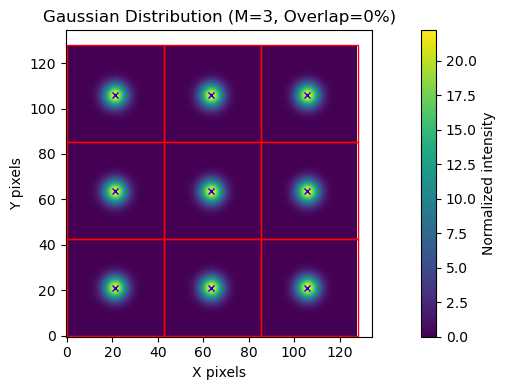


Test 2: 50% overlap (M=3, overlap=50%)
Diffraction limit parameters:
Airy disk radius: 6.710e-04 meters, 8.59 pixels
Gaussian width σ: 2.818e-04 meters, 3.61 pixels


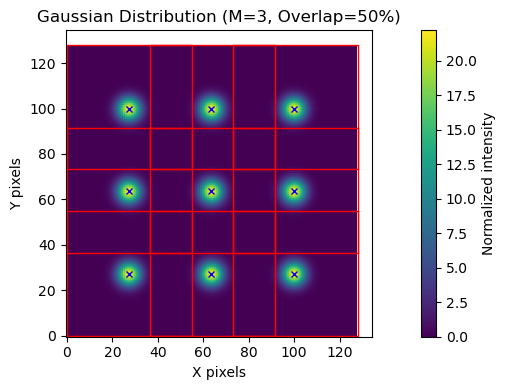


Test 3: 90% overlap (M=3, overlap=90%)
Diffraction limit parameters:
Airy disk radius: 6.710e-04 meters, 8.59 pixels
Gaussian width σ: 2.818e-04 meters, 3.61 pixels


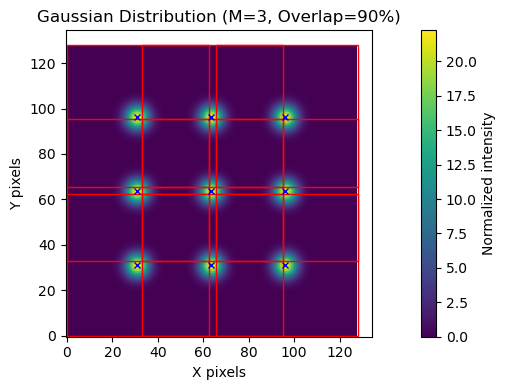

In [ ]:
"""
矩形排列高斯点阵生成
"""

import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

class PSFSimulator:
    def __init__(self, N=128, L=0.01, wavelength=550e-9, focal_length=0.1, device='cpu'):
        """
        Initialize parameters
        
        Parameters:
            N: Number of sampling points
            L: Physical size (meters)
            wavelength: Wavelength (meters)
            focal_length: Focal length (meters)
            device: Computing device
        """
        self.N = N
        self.L = L
        self.wavelength = wavelength
        self.focal_length = focal_length
        self.device = device
    
    def create_gaussian_template(self, size_factor=1.0, M=3, aperture_overlap_ratio=0.0):
        """
        Create Gaussian template with subregions layout
        
        Parameters:
            size_factor: Size factor controlling Gaussian width
            M: Number of Gaussians in x and y directions, total M×M
            aperture_overlap_ratio: Overlap ratio between adjacent subregions (0-1)
        
        Returns:
            Normalized Gaussian distribution, subregion info, and center positions
        """
        # Calculate diffraction-limited Airy disk radius (meters)
        r_airy = 1.22 * self.wavelength * self.focal_length * size_factor / self.L
        # Gaussian width parameter (meters)
        sigma = 0.42 * r_airy
        # Convert sigma to pixel units
        pitch = self.L / self.N  # Sampling interval (meters/pixel)
        sigma_px = sigma / pitch
        
        print(f"Diffraction limit parameters:")
        print(f"Airy disk radius: {r_airy:.3e} meters, {r_airy/pitch:.2f} pixels")
        print(f"Gaussian width σ: {sigma:.3e} meters, {sigma_px:.2f} pixels")
        
        # Create coordinate grid
        y = torch.arange(self.N, device=self.device)
        x = torch.arange(self.N, device=self.device)
        Y, X = torch.meshgrid(y, x, indexing='ij')
        
        # Calculate subregion size (considering overlap)
        region_size = (1 + aperture_overlap_ratio) / M
        
        # Calculate step size between adjacent subregion centers
        step = 1 / M
        
        # Calculate total space needed for the layout
        total_width = (M-1) * step + region_size
        
        # Calculate scaling factor to ensure layout fits within unit square
        scale = 1.0 / total_width
        
        # Apply scaling factor
        scaled_region_size = scale * region_size
        scaled_step = scale * step
        
        # Initialize accumulated Gaussian distribution as zero matrix
        gaussian_sum = torch.zeros((self.N, self.N), device=self.device)
        
        # Store subregion and center information
        subregions = []
        centers = []
        
        # Generate Gaussian distributions for each subregion
        for i in range(M):
            for j in range(M):
                # Calculate subregion top-left position
                region_left = i * scaled_step
                region_top = j * scaled_step
                
                # Store subregion boundary (left, top, width, height)
                subregions.append((region_left, region_top, scaled_region_size, scaled_region_size))
                
                # Calculate subregion center position
                center_x_norm = region_left + scaled_region_size / 2
                center_y_norm = region_top + scaled_region_size / 2
                
                # Store center position
                centers.append((center_x_norm, center_y_norm))
                
                # Convert to pixel coordinates
                center_x = center_x_norm * (self.N - 1)
                center_y = center_y_norm * (self.N - 1)
                
                # Calculate squared distance to the center
                dist_sq = (X - center_x)**2 + (Y - center_y)**2
                
                # Create Gaussian distribution
                gaussian = torch.exp(-0.5 * dist_sq / (sigma_px**2))
                
                # Add to accumulated sum
                gaussian_sum += gaussian
        
        # Normalize
        gaussian = gaussian_sum / torch.sum(gaussian_sum) * torch.numel(gaussian_sum)
        
        return gaussian, subregions, centers


def visualize_test(N=128, M=3, overlap_ratio=0.0, size_factor=100.0):
    """Test and visualize the Gaussian template generation with left-top aligned layout"""
    
    # Create simulator
    simulator = PSFSimulator(N=N)
    
    # Generate Gaussian template and subregion info
    gaussian, subregions, centers = simulator.create_gaussian_template(
        size_factor=size_factor, 
        M=M, 
        aperture_overlap_ratio=overlap_ratio
    )
    
    # Convert to numpy array for plotting
    gaussian_np = gaussian.cpu().numpy()
    
    # Calculate region size and scaling
    region_size = (1 + overlap_ratio) / M
    step = 1 / M
    total_width = (M-1) * step + region_size
    scale = 1.0 / total_width
    scaled_region_size = scale * region_size
    scaled_step = scale * step
    
    # Create figure 
    plt.figure(figsize=(10, 4))
    
    # Display the Gaussian distribution
    plt.imshow(gaussian_np, cmap='viridis', origin='lower')
    plt.colorbar(label='Normalized intensity')
    
    # Calculate region boundaries after scaling
    regions = []
    for i in range(M):
        for j in range(M):
            left = i * scaled_step
            top = j * scaled_step
            width = scaled_region_size
            height = scaled_region_size
            center_x = left + width/2
            center_y = top + height/2
            regions.append((left, top, width, height, center_x, center_y))
    
    # Draw subregion boundaries
    for i, (left, top, width, height, cx, cy) in enumerate(regions):
        # Convert normalized coordinates to pixel coordinates
        rect_left = left * N
        rect_top = top * N
        rect_width = width * N
        rect_height = height * N
        
        # Draw subregion rectangle
        rect = plt.Rectangle((rect_left, rect_top), rect_width, rect_height, 
                             fill=False, edgecolor='red', linewidth=1)
        plt.gca().add_patch(rect)
        
        # Draw center point
        plt.plot(cx * (N-1), cy * (N-1), 'bx', markersize=5)
    
    plt.title(f'Gaussian Distribution (M={M}, Overlap={overlap_ratio*100:.0f}%)')
    plt.xlabel('X pixels')
    plt.ylabel('Y pixels')
    plt.tight_layout()
    plt.show()

# Run tests with different configurations
print("Test 1: No overlap (M=3, overlap=0%)")
visualize_test(N=128, M=3, overlap_ratio=0.0)

print("\nTest 2: 50% overlap (M=3, overlap=50%)")
visualize_test(N=128, M=3, overlap_ratio=0.5)

print("\nTest 3: 90% overlap (M=3, overlap=90%)")
visualize_test(N=128, M=3, overlap_ratio=0.9)


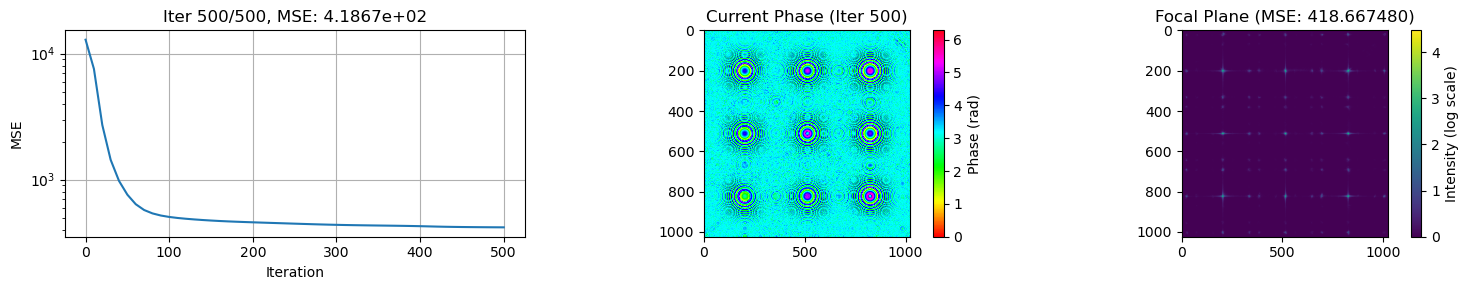

Finished. Time: 9.74 sec


<Figure size 1200x500 with 0 Axes>

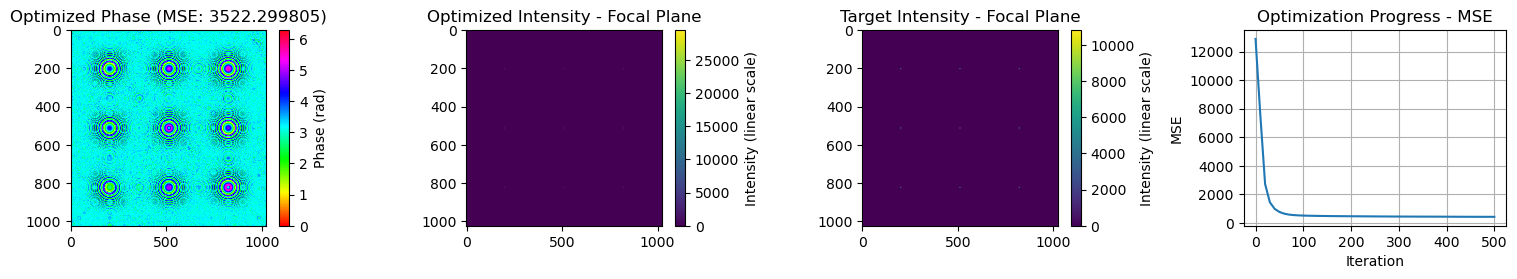

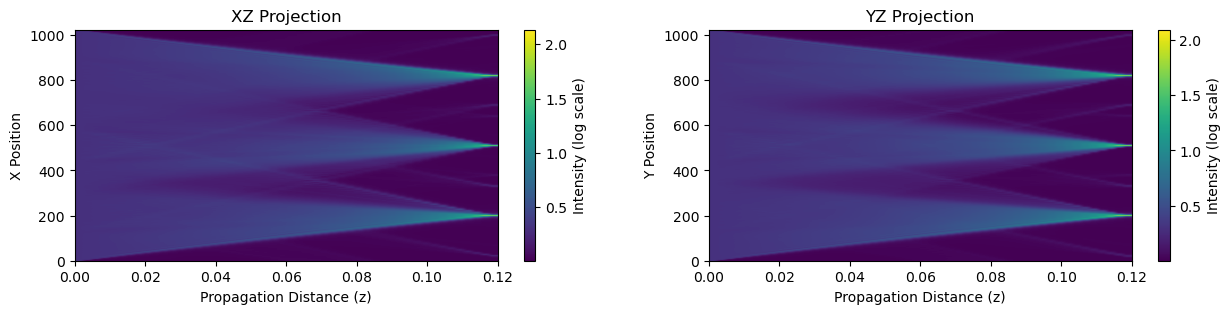

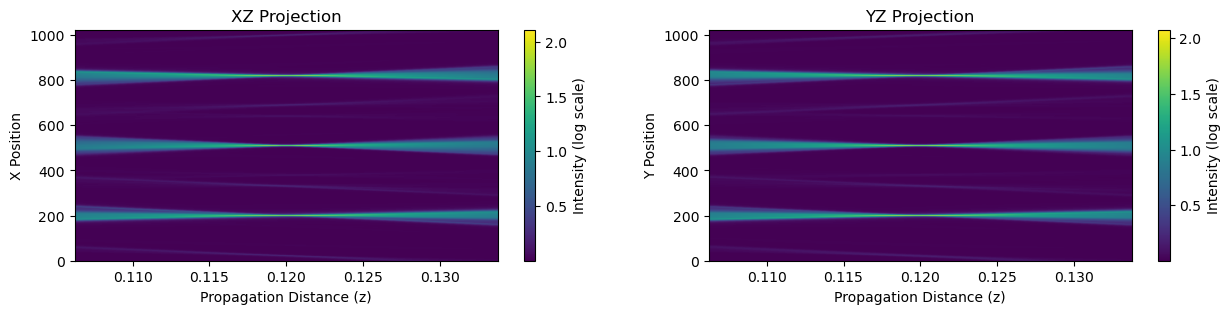

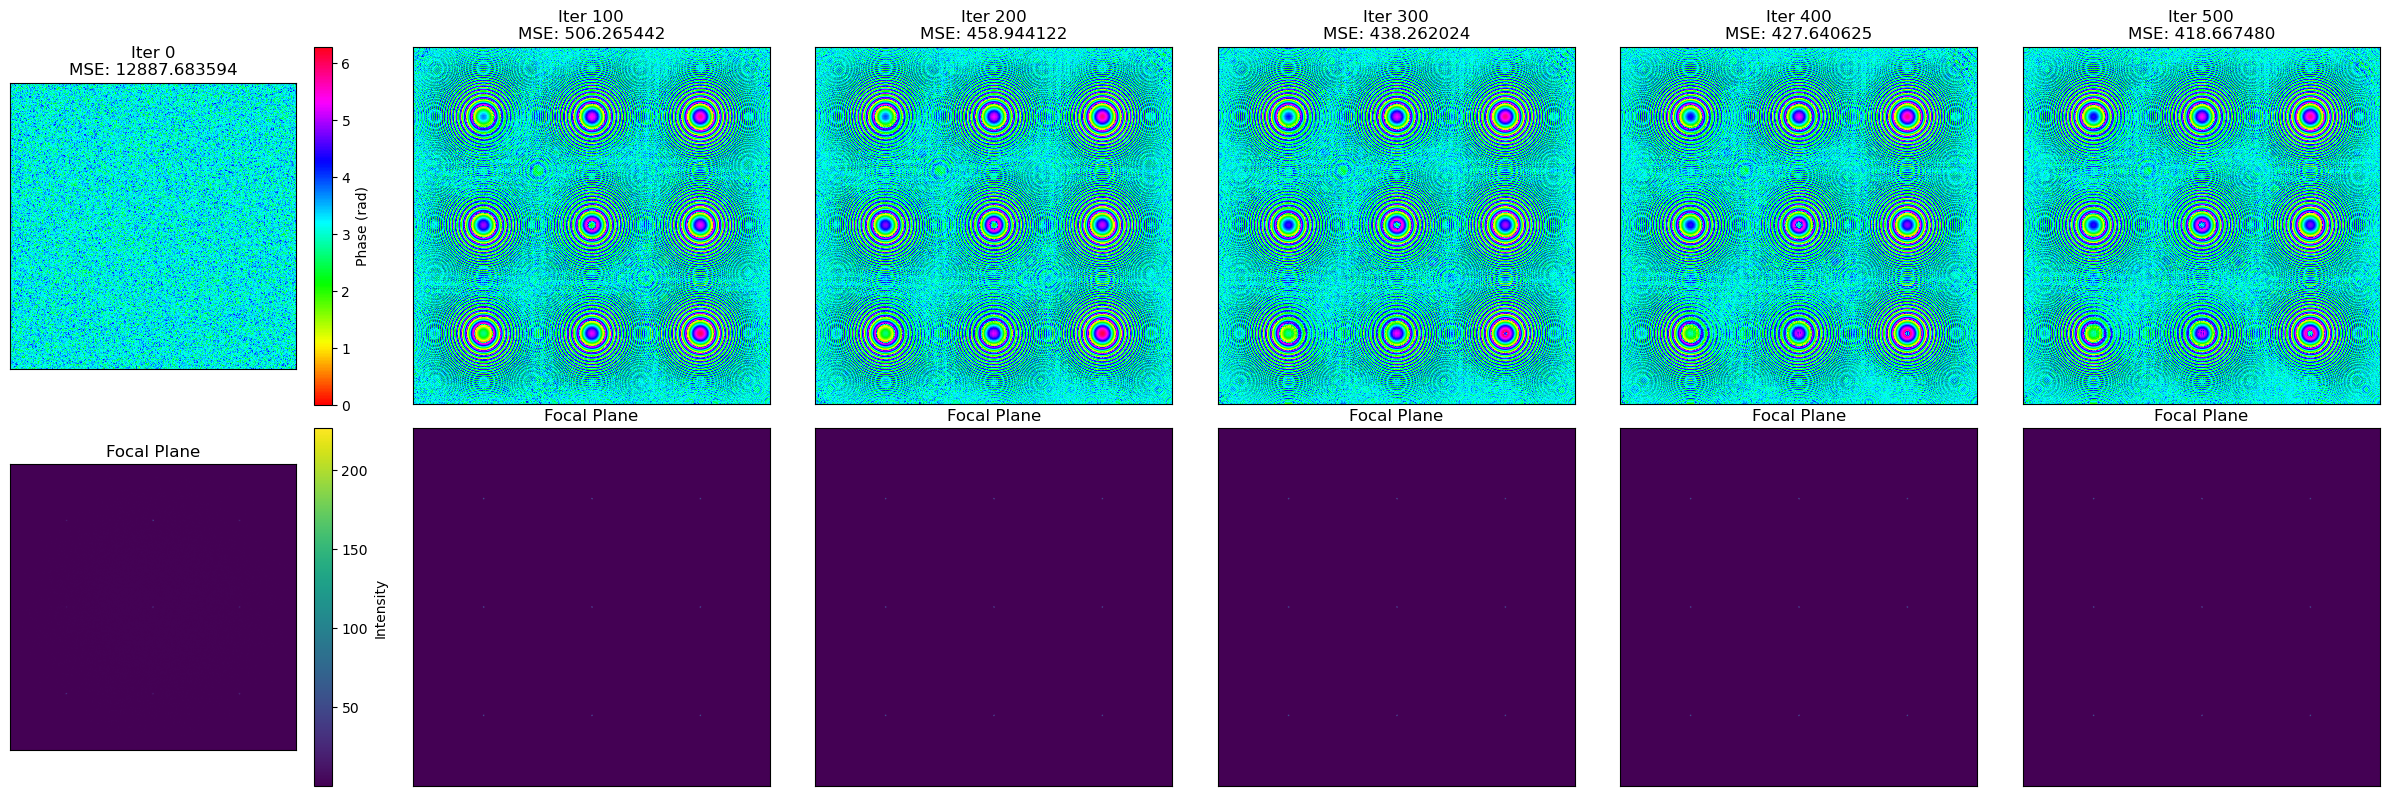

In [12]:
"""
矩形高斯模板阵列优化
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import wave_propagation as wp

class PhaseOptimizerMulti:
    
    def __init__(self, N, L, wavelength, focal_length, 
                 dof_tol_factor=2, 
                 size_factor=0.8, M=5, aperture_overlap_ratio=0.3,
                 device=None):
        self.N = N
        self.L = L
        self.wavelength = wavelength
        self.focal_length = focal_length
        self.dof_tol_factor = dof_tol_factor
        self.size_factor = size_factor
        self.M = M
        self.aperture_overlap_ratio = aperture_overlap_ratio
        self.depth_of_focus = 8*wavelength/np.pi*np.sqrt(self.dof_tol_factor**2-1)*(focal_length/L)**2
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"使用设备: {self.device}")
        
        # 创建坐标网格
        self.X, self.Y = wp.create_grid(L, N, self.device)
        
        # 初始化相位为随机值（需要梯度）
        self.random_phase = torch.rand((N, N), device=self.device) * 2 * np.pi
        self.phase_param = torch.nn.Parameter(self.random_phase.clone())
        
        # 入射场：单位振幅平面波
        self.U_in = torch.ones((N, N), device=self.device, dtype=torch.complex64)
        
        # 创建目标高斯模板
        self.target_gaussian = self.create_gaussian_template(self.size_factor, self.M, self.aperture_overlap_ratio)
        
        # 初始化历史记录
        self.loss_history = []
        self.mse_history = []
        self.phase_history = []
        
    def create_gaussian_template(self, size_factor=1.0, M=3, aperture_overlap_ratio=0.0):
        """
        Create Gaussian template with subregions layout
        
        Parameters:
            size_factor: Size factor controlling Gaussian width
            M: Number of Gaussians in x and y directions, total M×M
            aperture_overlap_ratio: Overlap ratio between adjacent subregions (0-1)
        
        Returns:
            Normalized Gaussian distribution, subregion info, and center positions
        """
        # Calculate diffraction-limited Airy disk radius (meters)
        r_airy = 1.22 * self.wavelength * self.focal_length * size_factor / self.L
        # Gaussian width parameter (meters)
        sigma = 0.42 * r_airy
        # Convert sigma to pixel units
        pitch = self.L / self.N  # Sampling interval (meters/pixel)
        sigma_px = sigma / pitch
        
        print(f"Diffraction limit parameters:")
        print(f"Airy disk radius: {r_airy:.3e} meters, {r_airy/pitch:.2f} pixels")
        print(f"Gaussian width σ: {sigma:.3e} meters, {sigma_px:.2f} pixels")
        
        # Create coordinate grid
        y = torch.arange(self.N, device=self.device)
        x = torch.arange(self.N, device=self.device)
        Y, X = torch.meshgrid(y, x, indexing='ij')
        
        # Calculate subregion size (considering overlap)
        region_size = (1 + aperture_overlap_ratio) / M
        
        # Calculate step size between adjacent subregion centers
        step = 1 / M
        
        # Calculate total space needed for the layout
        total_width = (M-1) * step + region_size
        
        # Calculate scaling factor to ensure layout fits within unit square
        scale = 1.0 / total_width
        
        # Apply scaling factor
        scaled_region_size = scale * region_size
        scaled_step = scale * step
        
        # Initialize accumulated Gaussian distribution as zero matrix
        gaussian_sum = torch.zeros((self.N, self.N), device=self.device)
        
        # Store subregion and center information
        subregions = []
        centers = []
        
        # Generate Gaussian distributions for each subregion
        for i in range(M):
            for j in range(M):
                # Calculate subregion top-left position
                region_left = i * scaled_step
                region_top = j * scaled_step
                
                # Store subregion boundary (left, top, width, height)
                subregions.append((region_left, region_top, scaled_region_size, scaled_region_size))
                
                # Calculate subregion center position
                center_x_norm = region_left + scaled_region_size / 2
                center_y_norm = region_top + scaled_region_size / 2
                
                # Store center position
                centers.append((center_x_norm, center_y_norm))
                
                # Convert to pixel coordinates
                center_x = center_x_norm * (self.N - 1)
                center_y = center_y_norm * (self.N - 1)
                
                # Calculate squared distance to the center
                dist_sq = (X - center_x)**2 + (Y - center_y)**2
                
                # Create Gaussian distribution
                gaussian = torch.exp(-0.5 * dist_sq / (sigma_px**2))
                
                # Add to accumulated sum
                gaussian_sum += gaussian
        
        # Normalize
        gaussian = gaussian_sum / torch.sum(gaussian_sum) * torch.numel(gaussian_sum)
        
        return gaussian


    def visualize_template(self):
        """visualize the Gaussian template generation with left-top aligned layout"""
                
        # Convert to numpy array for plotting
        gaussian_np = self.target_gaussian.cpu().numpy()
        
        # Calculate region size and scaling
        region_size = (1 + self.aperture_overlap_ratio) / self.M
        step = 1 / self.M
        total_width = (self.M-1) * step + region_size
        scale = 1.0 / total_width
        scaled_region_size = scale * region_size
        scaled_step = scale * step
        
        # Create figure 
        plt.figure(figsize=(10, 4))
        
        # Display the Gaussian distribution
        plt.imshow(gaussian_np, cmap='viridis', origin='lower')
        plt.colorbar(label='Normalized intensity')
        
        # Calculate region boundaries after scaling
        regions = []
        for i in range(self.M):
            for j in range(self.M):
                left = i * scaled_step
                top = j * scaled_step
                width = scaled_region_size
                height = scaled_region_size
                center_x = left + width/2
                center_y = top + height/2
                regions.append((left, top, width, height, center_x, center_y))
        
        # Draw subregion boundaries
        for i, (left, top, width, height, cx, cy) in enumerate(regions):
            # Convert normalized coordinates to pixel coordinates
            rect_left = left * self.N
            rect_top = top * self.N
            rect_width = width * self.N
            rect_height = height * self.N
            
            # Draw subregion rectangle
            rect = plt.Rectangle((rect_left, rect_top), rect_width, rect_height, 
                                fill=False, edgecolor='red', linewidth=1)
            plt.gca().add_patch(rect)
            
            # Draw center point
            plt.plot(cx * (self.N-1), cy * (self.N-1), 'bx', markersize=5)
        
        plt.title(f'Gaussian Distribution (M={self.M}, Overlap={self.aperture_overlap_ratio*100:.0f}%)')
        plt.xlabel('X pixels')
        plt.ylabel('Y pixels')
        plt.tight_layout()
        plt.show()
    
    def forward(self, phase, z):
        U_phase = self.U_in * torch.exp(1j * phase)
        U_focal = wp.propagate_ASM(U_phase, z, self.L, self.wavelength, self.device)
        I_focal = torch.abs(U_focal)**2
        return I_focal
    
    def compute_loss(self, phase):
        # 计算强度
        I_focal_1 = self.forward(phase, self.focal_length + self.depth_of_focus/2)
        I_focal_2 = self.forward(phase, self.focal_length - self.depth_of_focus/2)
        # 计算与高斯模板的MSE
        mse = torch.mean((I_focal_1 - self.target_gaussian)**2) + torch.mean((I_focal_2 - self.target_gaussian)**2)
        # # 计算强度
        # I_focal = self.forward(phase, self.focal_length)
        # # 计算与高斯模板的MSE
        # mse = torch.mean((I_focal - self.target_gaussian)**2)
        return mse, mse.item()
    
    def optimize(self, num_iterations=200, learning_rate=0.01, 
                save_interval=10, live_update=True):
        
        start_time = time.time()
        
        print(f"开始优化，共 {num_iterations} 次迭代...")
        
        # 创建优化器
        optimizer = torch.optim.Adam([self.phase_param], lr=learning_rate)
        
        # 创建图形对象（用于实时更新）
        if live_update:
            plt.figure(figsize=(12, 5))
        
        # 优化循环
        for iter_idx in range(num_iterations):
            # 零梯度
            optimizer.zero_grad()
            
            # 计算损失（与高斯模板的MSE）
            loss, mse = self.compute_loss(self.phase_param)
            
            # 反向传播
            loss.backward()
            
            # 更新参数
            optimizer.step()
            
            # 记录历史（每隔一定间隔）
            if iter_idx % save_interval == 0 or iter_idx == num_iterations - 1:
                self.loss_history.append(loss.item())
                self.mse_history.append(mse)
                self.phase_history.append(self.phase_param.detach().clone())
                
                # 实时可视化（仅在Jupyter中使用）
                if live_update and (iter_idx % (save_interval * 5) == 0 or iter_idx == num_iterations - 1):
                    clear_output(wait=True)
                    # 创建图形
                    plt.figure(figsize=(15, 3))
                    # 左：MSE曲线
                    plt.subplot(1, 3, 1)
                    plt.semilogy(np.arange(len(self.mse_history)) * save_interval, self.mse_history)
                    plt.grid(True)
                    plt.xlabel('Iteration')
                    plt.ylabel('MSE')
                    plt.title(f'Iter {iter_idx+1}/{num_iterations}, MSE: {mse:.4e}')
                    # 中：当前相位
                    plt.subplot(1, 3, 2)
                    wrapped_phase = torch.remainder(self.phase_param.detach(), 2*np.pi).cpu().numpy()
                    plt.imshow(wrapped_phase, cmap='hsv', vmin=0, vmax=2*np.pi)
                    plt.colorbar(label='Phase (rad)')
                    plt.title(f'Current Phase (Iter {iter_idx+1})')
                    # 右：当前焦平面强度
                    plt.subplot(1, 3, 3)
                    I_focal = self.forward(self.phase_param.detach(), self.focal_length)
                    plt.imshow(np.log10(1+I_focal.cpu().numpy()), cmap='viridis')
                    plt.colorbar(label='Intensity (log scale)')
                    plt.title(f'Focal Plane (MSE: {mse:.6f})')
                    
                    plt.tight_layout()
                    display(plt.gcf())
                    plt.close()
                    
        
        # 获取优化后的相位
        optimized_phase = self.phase_param.detach().clone()
        
        # 优化完成
        elapsed_time = time.time() - start_time
        print(f"Finished. Time: {elapsed_time:.2f} sec")
        
        return optimized_phase
    
    def visualize_results(self, optimized_phase):
        """
        可视化优化结果
        
        参数:
            optimized_phase: 优化后的相位分布
        """
        # 相位包裹到 0-2π
        wrapped_optimized = torch.remainder(optimized_phase, 2*np.pi).cpu().numpy()
        
        # 计算各阶段的焦平面场和强度
        I_optimized = self.forward(optimized_phase, self.focal_length)
        
        # 计算与高斯模板的MSE
        mse_optimized = torch.mean((I_optimized - self.target_gaussian)**2).item()
        
        
        # 创建图形
        plt.figure(figsize=(15, 5))
        
        # 1. 相位分布
        plt.subplot(2, 4, 1)
        plt.imshow(wrapped_optimized, cmap='hsv', vmin=0, vmax=2*np.pi)
        plt.colorbar(label='Phase (rad)')
        plt.title(f'Optimized Phase (MSE: {mse_optimized:.6f})')
        
        # 2. 焦平面强度
        plt.subplot(2, 4, 2)
        plt.imshow(I_optimized.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Intensity (linear scale)')
        plt.title('Optimized Intensity - Focal Plane')
        
        # 2. 焦平面强度
        plt.subplot(2, 4, 3)
        plt.imshow(self.target_gaussian.cpu().numpy(), cmap='viridis')
        plt.colorbar(label='Intensity (linear scale)')
        plt.title('Target Intensity - Focal Plane')
        
        # 优化过程
        plt.subplot(2, 4, 4)
        plt.plot(np.arange(len(self.mse_history)) * 10, self.mse_history)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Optimization Progress - MSE')
        
        
        plt.tight_layout()
        plt.show()
        
    
    def visualize_optimization_steps(self, num_steps=5):
        """
        可视化优化过程中的关键步骤（适用于Jupyter Notebook）
        
        参数:
            num_steps: 要显示的步骤数量
        """
        if len(self.phase_history) < num_steps:
            print(f"历史记录不足，仅有{len(self.phase_history)}个记录点")
            num_steps = len(self.phase_history)
        
        # 选择要显示的步骤
        step_indices = np.linspace(0, len(self.phase_history) - 1, num_steps, dtype=int)
        
        # 创建大图形
        fig, axes = plt.subplots(2, num_steps, figsize=(4*num_steps, 8))
        
        for i, idx in enumerate(step_indices):
            # 获取该步骤的相位和MSE
            phase = self.phase_history[idx]
            mse = self.mse_history[idx]
            iteration = idx * 10  # 假设每10次迭代保存一次
            
            # 包裹相位
            wrapped_phase = torch.remainder(phase, 2*np.pi).cpu().numpy()
            
            # 计算焦平面强度
            I_focal = self.forward(phase, self.focal_length)
            
            # 绘制相位
            ax_phase = axes[0, i]
            im_phase = ax_phase.imshow(wrapped_phase, cmap='hsv', vmin=0, vmax=2*np.pi)
            ax_phase.set_title(f'Iter {iteration}\nMSE: {mse:.6f}')
            if i == 0:
                fig.colorbar(im_phase, ax=ax_phase, label='Phase (rad)')
            
            # 绘制焦平面强度
            ax_focal = axes[1, i]
            im_focal = ax_focal.imshow(I_focal.cpu().numpy(), cmap='viridis')
            ax_focal.set_title('Focal Plane')
            if i == 0:
                fig.colorbar(im_focal, ax=ax_focal, label='Intensity')
                
            # 移除刻度以简化显示
            ax_phase.set_xticks([])
            ax_phase.set_yticks([])
            ax_focal.set_xticks([])
            ax_focal.set_yticks([])
        
        plt.tight_layout()
        plt.show()
    
    def visualize_prop(self, optimized_phase, z_start, z_end, z_samples = 50, log_scale=True):
        # 定义采样范围
        z_values = np.linspace(z_start, z_end, z_samples)

        # 获取焦平面强度的形状来初始化3D数组
        intensity_3d = np.zeros((self.N, self.N, z_samples))

        # 计算每个z位置的强度
        for i, z_distance in enumerate(z_values):
            # 计算该传播距离处的场
            intensity_3d[:, :, i] = self.forward(optimized_phase, z_distance).cpu().numpy()

        # 通过平均计算投影
        # xz投影: 沿y轴(axis 0)平均
        xz_projection = np.mean(intensity_3d, axis=0)  # 形状: (width, z_samples)
        # yz投影: 沿x轴(axis 1)平均
        yz_projection = np.mean(intensity_3d, axis=1)  # 形状: (height, z_samples)

        plt.figure(figsize=(15, 3))
        # 绘制xz投影(x vs z)并使用对数缩放
        plt.subplot(1, 2, 1)
        if log_scale:
            plt.imshow(np.log10(1+xz_projection), cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (log scale)')
        else:
            plt.imshow(xz_projection, cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (linear scale)')
        plt.title('XZ Projection')
        plt.xlabel('Propagation Distance (z)')
        plt.ylabel('X Position')

        # 绘制yz投影(y vs z)并使用对数缩放
        plt.subplot(1, 2, 2)
        if log_scale:
            plt.imshow(np.log10(1+yz_projection), cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (log scale)')
        else:
            plt.imshow(yz_projection, cmap='viridis', aspect='auto',
                    extent=[z_start, z_end, 0, self.N])
            plt.colorbar(label='Intensity (linear scale)')
        plt.title('YZ Projection')
        plt.xlabel('Propagation Distance (z)')
        plt.ylabel('Y Position')

# 主函数示例
"""
运行基于修正高斯模板的优化程序
"""
# 设置参数
N = 1024             # 网格点数
L = 0.010           # 计算区域大小（10mm）
wavelength = 635e-9  # 波长（635nm）
focal_length = 0.120 # 焦距（mm）
size_factor = 3 # 调整目标psf大小
M = 3 # 阵列规模
aperture_overlap_ratio = 0.3

# 创建优化器
optimizer = PhaseOptimizerMulti(N, L, wavelength, focal_length, 
                                dof_tol_factor=6, 
                                size_factor=size_factor, 
                                M=M, aperture_overlap_ratio=aperture_overlap_ratio)

optimizer.visualize_template()

# 优化相位
num_iterations = 500
learning_rate = 0.1
optimized_phase = optimizer.optimize(
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    save_interval=10,
    live_update=True  # 在Jupyter中实时更新
)

# 可视化最终结果
optimizer.visualize_results(optimized_phase)

# 可视化传播投影
optimizer.visualize_prop(optimized_phase, 
                         z_start=0, z_end=optimizer.focal_length,
                         z_samples=50, log_scale=True)
optimizer.visualize_prop(optimized_phase, 
                         z_start=optimizer.focal_length-10*optimizer.depth_of_focus,
                         z_end=optimizer.focal_length+10*optimizer.depth_of_focus,
                         z_samples=50, log_scale=True)

# 可视化优化过程关键步骤
optimizer.visualize_optimization_steps(num_steps=6)

衍射极限参数:
艾里斑半径: 6.710e-04 米, 8.59 像素
高斯宽度σ: 2.818e-04 米, 3.61 像素


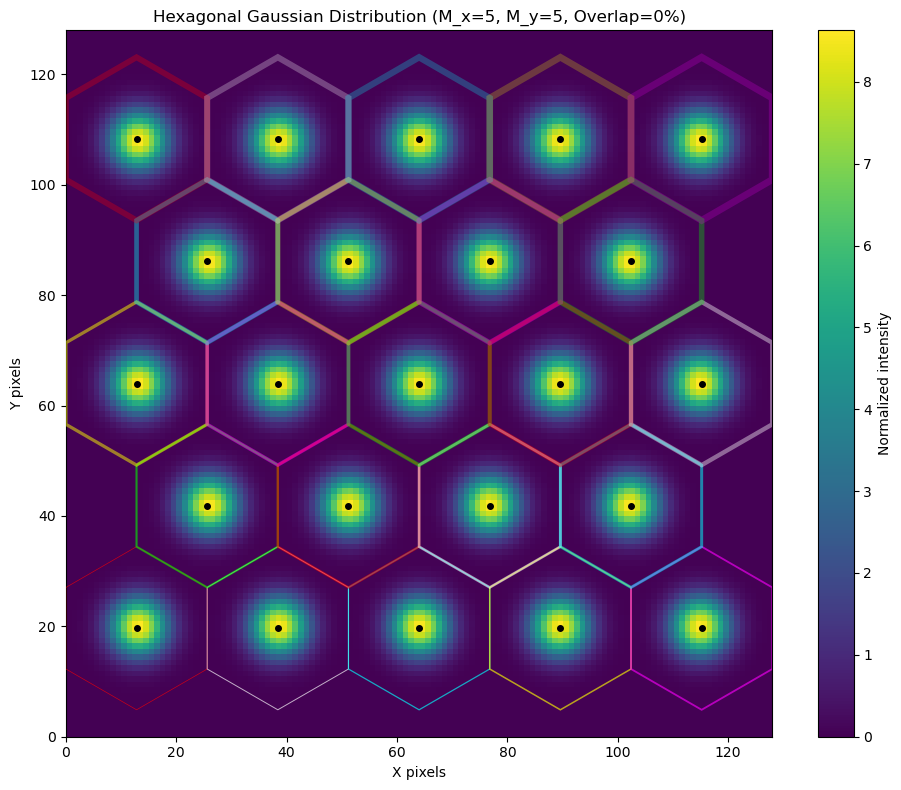

衍射极限参数:
艾里斑半径: 6.710e-04 米, 8.59 像素
高斯宽度σ: 2.818e-04 米, 3.61 像素


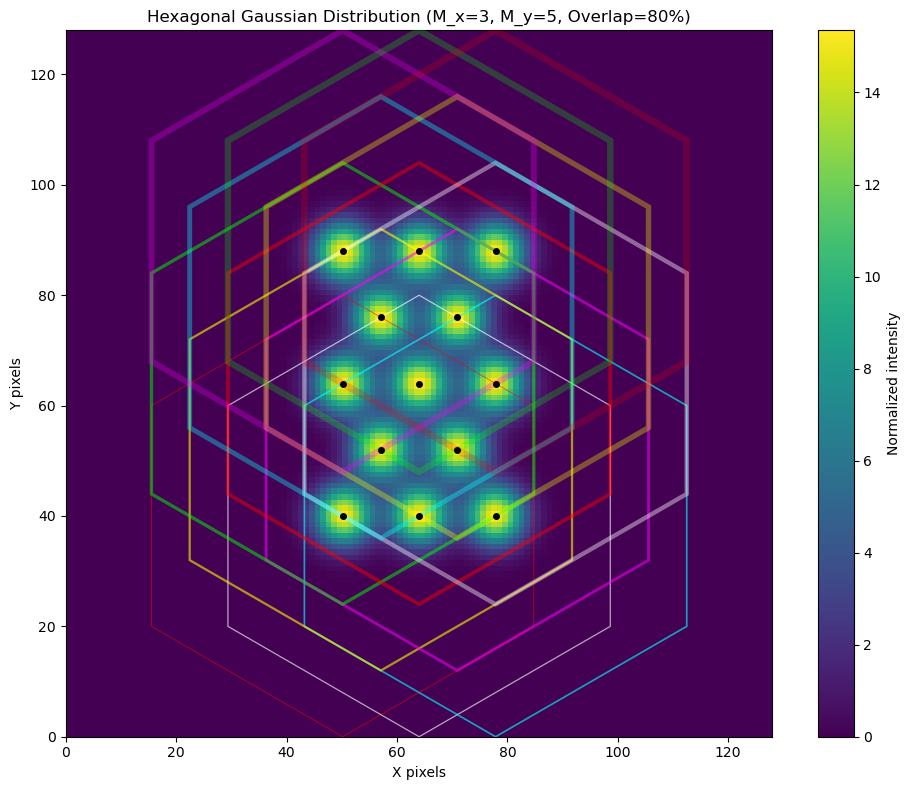

衍射极限参数:
艾里斑半径: 6.710e-04 米, 8.59 像素
高斯宽度σ: 2.818e-04 米, 3.61 像素


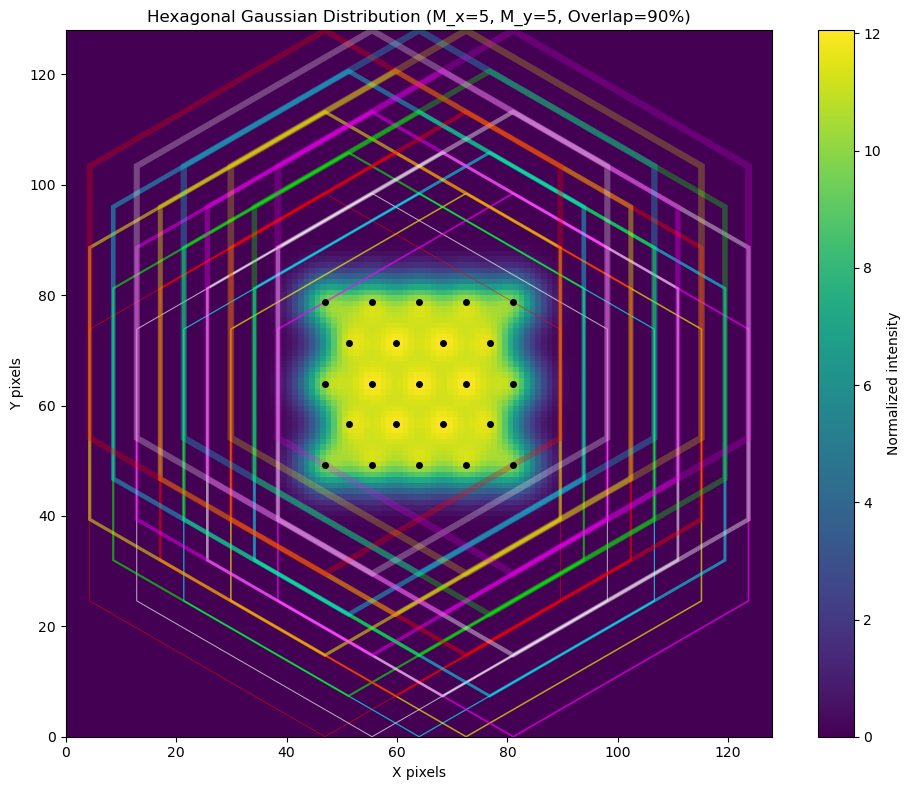

衍射极限参数:
艾里斑半径: 6.710e-04 米, 8.59 像素
高斯宽度σ: 2.818e-04 米, 3.61 像素


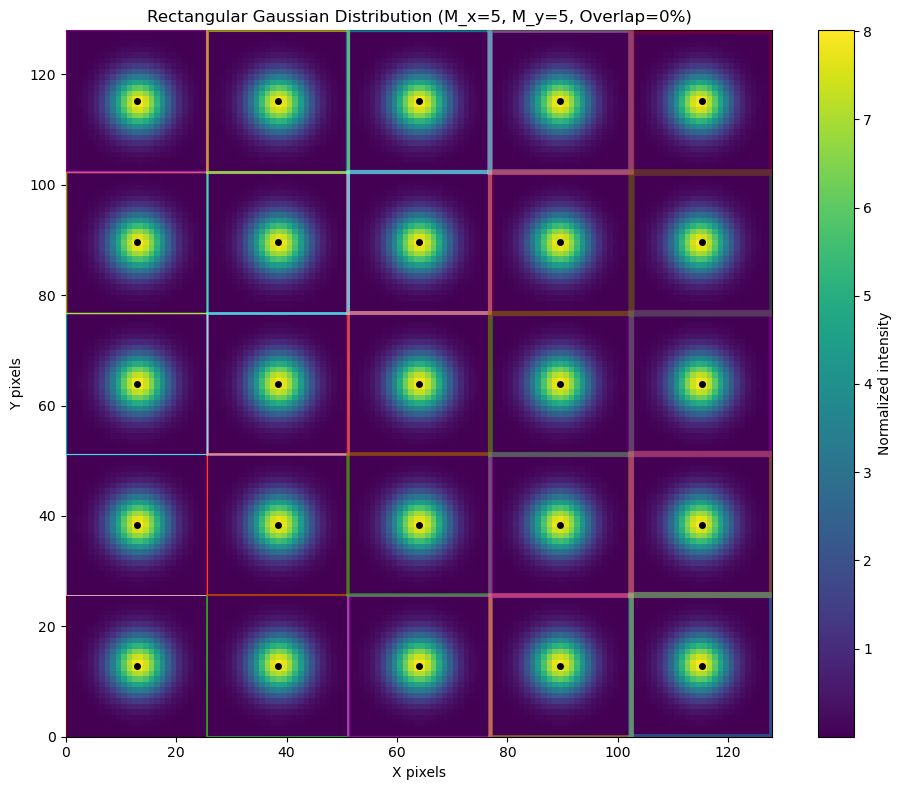

衍射极限参数:
艾里斑半径: 6.710e-04 米, 8.59 像素
高斯宽度σ: 2.818e-04 米, 3.61 像素


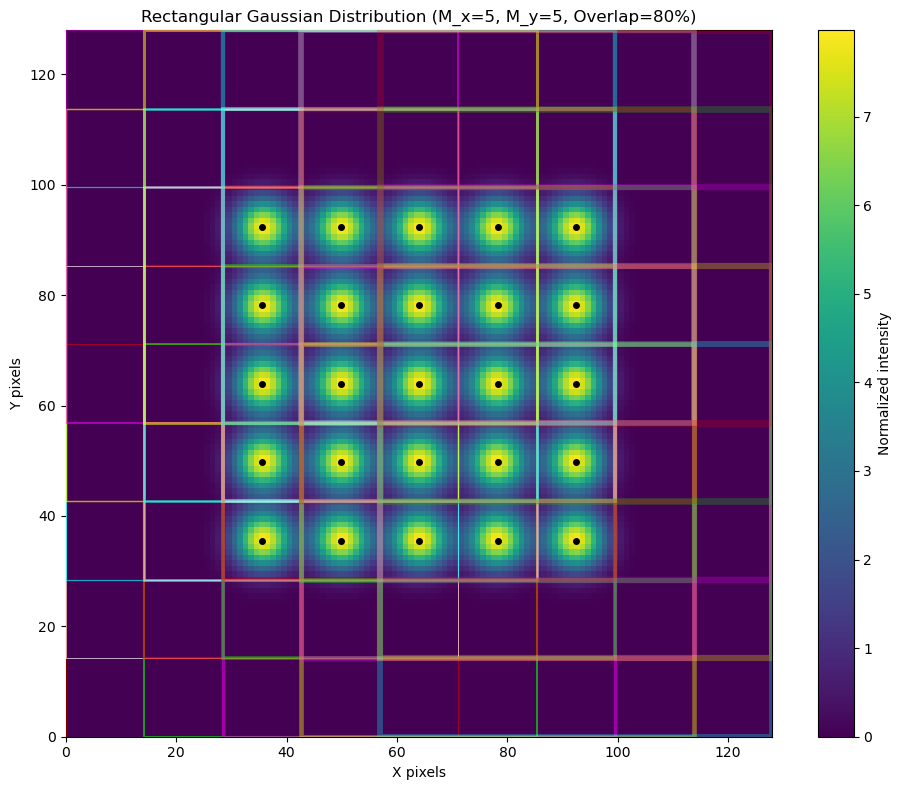

衍射极限参数:
艾里斑半径: 6.710e-04 米, 8.59 像素
高斯宽度σ: 2.818e-04 米, 3.61 像素


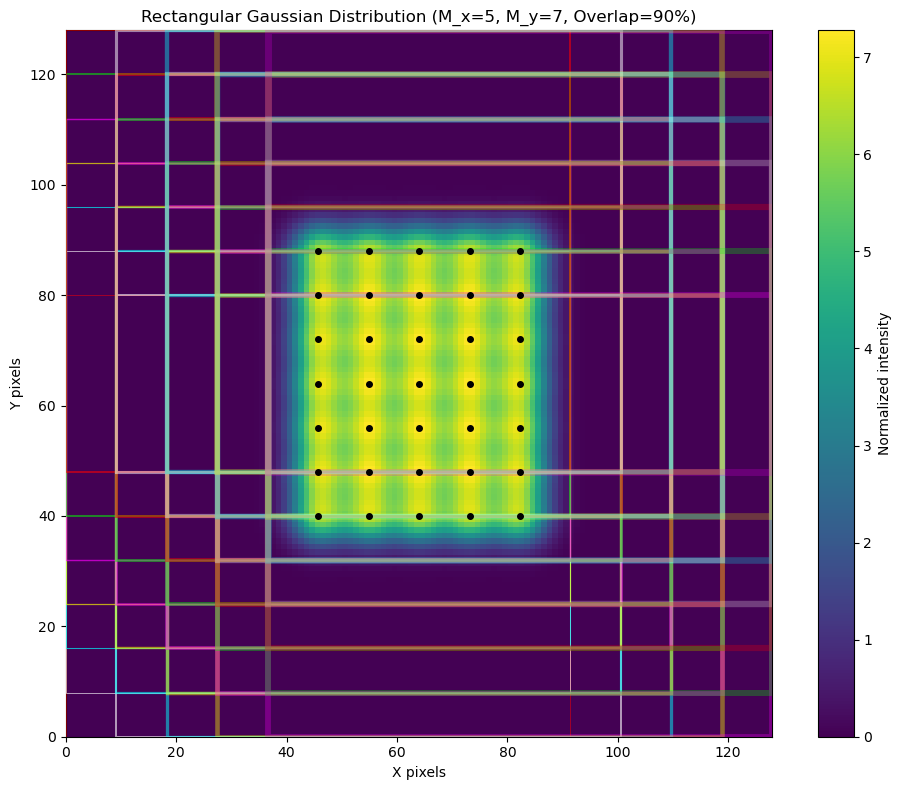

In [74]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.patches import Polygon, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection


# 为了测试方便，这里也包含核心类的定义
class PSFSimulator:
    def __init__(self, N=128, L=0.01, wavelength=550e-9, focal_length=0.1, device='cpu'):
        """
        初始化PSF模拟器
        
        参数:
            N: 采样点数
            L: 物理尺寸 (米)
            wavelength: 波长 (米)
            focal_length: 焦距 (米)
            device: 计算设备
        """
        self.N = N
        self.L = L
        self.wavelength = wavelength
        self.focal_length = focal_length
        self.device = device
    
    def create_gaussian_template(self, size_factor=1.0, M_x=3, M_y=None, aperture_overlap_ratio=0.0, pattern="rectangular"):
        """
        创建高斯模板
        
        参数:
            size_factor: 尺寸因子，控制高斯宽度
            M_x: x方向上放置高斯的数量
            M_y: y方向上放置高斯的数量，若为None则设为与M_x相同
            aperture_overlap_ratio: 相邻子区域的重叠比例（0-1之间）
            pattern: 排列方式，"rectangular"或"hexagonal"
        
        返回:
            归一化后的高斯分布, 子区域信息, 中心点位置
        """
        # 计算衍射极限的艾里斑半径（单位：米）
        r_airy = 1.22 * self.wavelength * self.focal_length * size_factor / self.L
        # 高斯宽度参数（单位：米）
        # 标准偏差sigma约为艾里半径的0.42倍
        sigma = 0.42 * r_airy
        # 将sigma转换为像素单位
        pitch = self.L / self.N  # 采样间隔（米/像素）
        sigma_px = sigma / pitch
        
        # 若M_y未指定，则设为与M_x相同
        if M_y is None:
            M_y = M_x
        
        print(f"衍射极限参数:")
        print(f"艾里斑半径: {r_airy:.3e} 米, {r_airy/pitch:.2f} 像素")
        print(f"高斯宽度σ: {sigma:.3e} 米, {sigma_px:.2f} 像素")
        
        # 创建坐标网格
        y = torch.arange(self.N, device=self.device)
        x = torch.arange(self.N, device=self.device)
        Y, X = torch.meshgrid(y, x, indexing='ij')
        
        # 初始化累积高斯分布为零矩阵
        gaussian_sum = torch.zeros((self.N, self.N), device=self.device)
        
        # 存储子区域和中心信息（用于可视化）
        subregions = []
        centers = []
        
        if pattern == "hexagonal":
            # 六边形密排布局
            
            rows = M_y
            cols = M_x
            
            # 计算重叠因子
            overlap_factor = 1.0 - aperture_overlap_ratio
            
            # 计算六边形网格的几何参数
            # 对于六边形的边长，我们需要考虑要放置的数量和重叠度
            
            # 计算水平方向的布局
            # 相邻两列中心的水平距离为边长*sqrt(3)*overlap_factor
            # 总宽度需要涵盖M_x列，同时最左和最右的六边形需要恰好触及边界
            # 注意：六边形从中心到边的距离是边长*cos(30°) = 边长*sqrt(3)/2
            
            # 总宽度：(cols-1)*h_spacing + 边长*sqrt(3) = 1.0
            # 解出边长: side_length = 1.0 / (sqrt(3) + (cols-1)*sqrt(3)*overlap_factor)
            
            side_length_x = 1.0 / (math.sqrt(3) + (cols-1) * math.sqrt(3) * overlap_factor)
            
            # 计算垂直方向的布局
            # 相邻两行中心的垂直距离为边长*1.5*overlap_factor
            # 六边形的高度为边长*2
            # 我们需要确保第一行和最后一行的六边形恰好触及上下边界
            
            # 总高度：(rows-1)*v_spacing + 边长*2 = 1.0
            # 解出边长: side_length = 1.0 / (2 + (rows-1)*1.5*overlap_factor)
            
            side_length_y = 1.0 / (2 + (rows-1) * 1.5 * overlap_factor)
            
            # 取较小的值确保两个方向都适配
            side_length = min(side_length_x, side_length_y)
            
            # 计算六边形的各种尺寸
            hex_width = side_length * math.sqrt(3)  # 六边形宽度（边对边）
            hex_height = side_length * 2  # 六边形高度（顶点对顶点）
            
            # 计算中心间距
            h_spacing = side_length * math.sqrt(3) * overlap_factor  # 水平方向上的中心间距
            v_spacing = side_length * 1.5 * overlap_factor  # 垂直方向上的中心间距
            
            # 计算实际布局的总宽度和高度
            total_width = (cols-1) * h_spacing + hex_width
            total_height = (rows-1) * v_spacing + hex_height
            
            # 计算偏移量使得布局居中且边缘六边形恰好触及边界
            offset_x = (1.0 - total_width) / 2
            offset_y = (1.0 - total_height) / 2
            
            # 生成六边形网格
            for row in range(rows):
                # 奇偶行交错
                row_offset = h_spacing / 2 if row % 2 == 1 else 0
                col_count = cols - (1 if row % 2 == 1 else 0)  # 奇数行可能少一列
                
                for col in range(col_count):
                    # 计算六边形中心
                    center_x = offset_x + hex_width/2 + col * h_spacing + row_offset
                    center_y = offset_y + hex_height/2 + row * v_spacing
                    
                    # 确保中心点在合理范围内
                    if center_x < 0 or center_x > 1 or center_y < 0 or center_y > 1:
                        continue
                    
                    # 存储中心位置
                    centers.append((center_x, center_y))
                    
                    # 计算六边形的六个顶点（用于可视化）
                    vertices = []
                    for i in range(6):
                        angle = 2 * math.pi / 6 * i - 2 * math.pi / 12
                        vx = center_x + side_length * math.cos(angle)
                        vy = center_y + side_length * math.sin(angle)
                        vertices.append((vx, vy))
                    subregions.append(vertices)
                    
                    # 转换为像素坐标
                    center_x_px = center_x * (self.N - 1)
                    center_y_px = center_y * (self.N - 1)
                    
                    # 计算到该中心的距离平方
                    dist_sq = (X - center_x_px)**2 + (Y - center_y_px)**2
                    
                    # 创建高斯分布
                    gaussian = torch.exp(-0.5 * dist_sq / (sigma_px**2))
                    
                    # 添加到累积总和
                    gaussian_sum += gaussian
        else:
            # 矩形网格布局
            
            # 计算重叠因子
            overlap_factor = 1.0 - aperture_overlap_ratio
            
            # 计算矩形尺寸，考虑重叠和边界对齐
            # 解方程：总宽度 = 矩形宽度 + (M_x-1) * 矩形间距 = 1.0
            # 其中矩形间距 = 矩形宽度 * overlap_factor
            # 因此：矩形宽度 * (1 + (M_x-1)*overlap_factor) = 1.0
            region_size_x = 1.0 / (1 + (M_x-1) * overlap_factor)
            region_size_y = 1.0 / (1 + (M_y-1) * overlap_factor)
            
            # 计算矩形中心之间的步长
            step_x = region_size_x * overlap_factor
            step_y = region_size_y * overlap_factor
            
            # 为每个子区域生成高斯分布
            for i in range(M_x):
                for j in range(M_y):
                    # 计算子区域左上角位置和中心位置
                    if M_x == 1:
                        # 如果只有一个矩形，则居中放置
                        center_x_norm = 0.5
                        region_left = center_x_norm - region_size_x / 2
                    else:
                        # 否则均匀分布
                        region_left = i * step_x
                        center_x_norm = region_left + region_size_x / 2
                    
                    if M_y == 1:
                        # 如果只有一个矩形，则居中放置
                        center_y_norm = 0.5
                        region_top = center_y_norm - region_size_y / 2
                    else:
                        # 否则均匀分布
                        region_top = j * step_y
                        center_y_norm = region_top + region_size_y / 2
                    
                    # 子区域信息（存储矩形的左上角和尺寸）
                    subregions.append((region_left, region_top, region_size_x, region_size_y))
                    
                    # 存储中心位置
                    centers.append((center_x_norm, center_y_norm))
                    
                    # 转换为像素坐标
                    center_x = center_x_norm * (self.N - 1)
                    center_y = center_y_norm * (self.N - 1)
                    
                    # 计算到该中心的距离平方
                    dist_sq = (X - center_x)**2 + (Y - center_y)**2
                    
                    # 创建高斯分布
                    gaussian = torch.exp(-0.5 * dist_sq / (sigma_px**2))
                    
                    # 添加到累积总和
                    gaussian_sum += gaussian
        
        # 归一化
        gaussian = gaussian_sum / torch.sum(gaussian_sum) * torch.numel(gaussian_sum)
        
        return gaussian, subregions, centers

def test_gaussian_template(N=128, M_x=3, M_y=None, overlap_ratio=0.0, pattern="rectangular"):
    """
    测试高斯模板生成并显示结果
    
    参数:
        N: 图像尺寸（像素）
        M_x: x方向子区域数量
        M_y: y方向子区域数量
        overlap_ratio: 重叠比例 (0-1)
        pattern: 排列模式 ("rectangular" 或 "hexagonal")
    """
    # 创建模拟器
    simulator = PSFSimulator(N=N)
    
    # 生成高斯模板
    gaussian, subregions, centers = simulator.create_gaussian_template(
        size_factor=100.0, 
        M_x=M_x, 
        M_y=M_y,
        aperture_overlap_ratio=overlap_ratio,
        pattern=pattern
    )
    
    # 确保M_y有值（用于显示）
    if M_y is None:
        M_y = M_x
    
    # 转换为Numpy数组用于绘图
    gaussian_np = gaussian.cpu().numpy()
    
    # 创建图形
    plt.figure(figsize=(10, 8))
    
    # 显示高斯分布
    plt.imshow(gaussian_np, cmap='viridis', origin='lower',
               extent=[0, N, 0, N], interpolation='nearest')
    plt.colorbar(label='Normalized intensity')
    
    # 定义一组用于交替的颜色
    border_colors = ['red', 'white', 'cyan', 'yellow', 'magenta', 'lime']
    
    
    # 定义线宽范围，增加层次感
    min_linewidth = 0.5
    max_linewidth = 5
    
    # 计算总区域数量
    total_regions = len(subregions)
    
    # 根据模式绘制子区域边界 - 反向绘制，使索引小的在上层
    if pattern == "hexagonal":
        # 对于六边形模式，绘制多边形
        for i, vertices in enumerate(reversed(subregions)):
            # 计算原始索引
            orig_idx = total_regions - i - 1
            
            # 选择颜色（循环使用颜色列表）
            color = border_colors[orig_idx % len(border_colors)]
            
            # 计算线宽 - 索引越大，线宽越大，增加层次感
            linewidth = min_linewidth + (max_linewidth - min_linewidth) * (orig_idx / max(1, total_regions - 1))
            
            # 透明度 
            alpha = 1-(0.3 + 0.5 * (orig_idx / max(1, total_regions - 1)))
            
            # 转换归一化坐标为像素坐标
            pixel_vertices = [(v[0]*N, v[1]*N) for v in vertices]
            polygon = Polygon(pixel_vertices, closed=True, fill=False, 
                             edgecolor=color, linewidth=linewidth,
                             alpha=alpha, zorder=10+orig_idx)
            plt.gca().add_patch(polygon)
    else:
        # 对于矩形模式，绘制矩形
        for i, (left, top, width, height) in enumerate(reversed(subregions)):
            # 计算原始索引
            orig_idx = total_regions - i - 1
            
            # 选择颜色（循环使用颜色列表）
            color = border_colors[orig_idx % len(border_colors)]
            
            # 计算线宽 - 索引越大，线宽越大，增加层次感
            linewidth = min_linewidth + (max_linewidth - min_linewidth) * (orig_idx / max(1, total_regions - 1))
            
            # 透明度 
            alpha = 1-(0.3 + 0.5 * (orig_idx / max(1, total_regions - 1)))
            
            rect = plt.Rectangle((left*N, top*N), width*N, height*N,
                                fill=False, edgecolor=color, linewidth=linewidth,
                                alpha=alpha, zorder=10+orig_idx)
            plt.gca().add_patch(rect)
    
    # 绘制中心点
    for cx, cy in centers:
        cx_px = cx * N
        cy_px = cy * N
        plt.plot(cx_px, cy_px, 'ko', markersize=4, zorder=100)  # 使用黑色圆点，并确保在最上层
    
    # 添加标题和标签
    pattern_name = "Hexagonal" if pattern == "hexagonal" else "Rectangular"
    plt.title(f'{pattern_name} Gaussian Distribution (M_x={M_x}, M_y={M_y}, Overlap={overlap_ratio*100:.0f}%)')
    plt.xlabel('X pixels')
    plt.ylabel('Y pixels')
    
    plt.tight_layout()
    plt.show()

# 测试六边形布局
test_gaussian_template(N=128, M_x=5, M_y=5, overlap_ratio=0.0, pattern="hexagonal")

test_gaussian_template(N=128, M_x=3, M_y=5, overlap_ratio=0.8, pattern="hexagonal")

test_gaussian_template(N=128, M_x=5, M_y=5, overlap_ratio=0.9, pattern="hexagonal")

test_gaussian_template(N=128, M_x=5, M_y=5, overlap_ratio=0, pattern="rectangular")

test_gaussian_template(N=128, M_x=5, M_y=5, overlap_ratio=0.8, pattern="rectangular")

test_gaussian_template(N=128, M_x=5, M_y=7, overlap_ratio=0.9, pattern="rectangular")

